Anna K, last edit 05.09.2023

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta, datetime, date, time, timezone
import datetime as dt
import numpy as np

In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

### Loading dataframe

In [3]:
data = pd.read_csv("../data/preprocessed_database_telegram_git.csv")
data = data.copy()

### Fixing date to Datetime and setting it as an index

In [4]:
data['date'] = pd.to_datetime(data["date"])
data = data.set_index("date")

### Checking the data

<AxesSubplot:xlabel='date'>

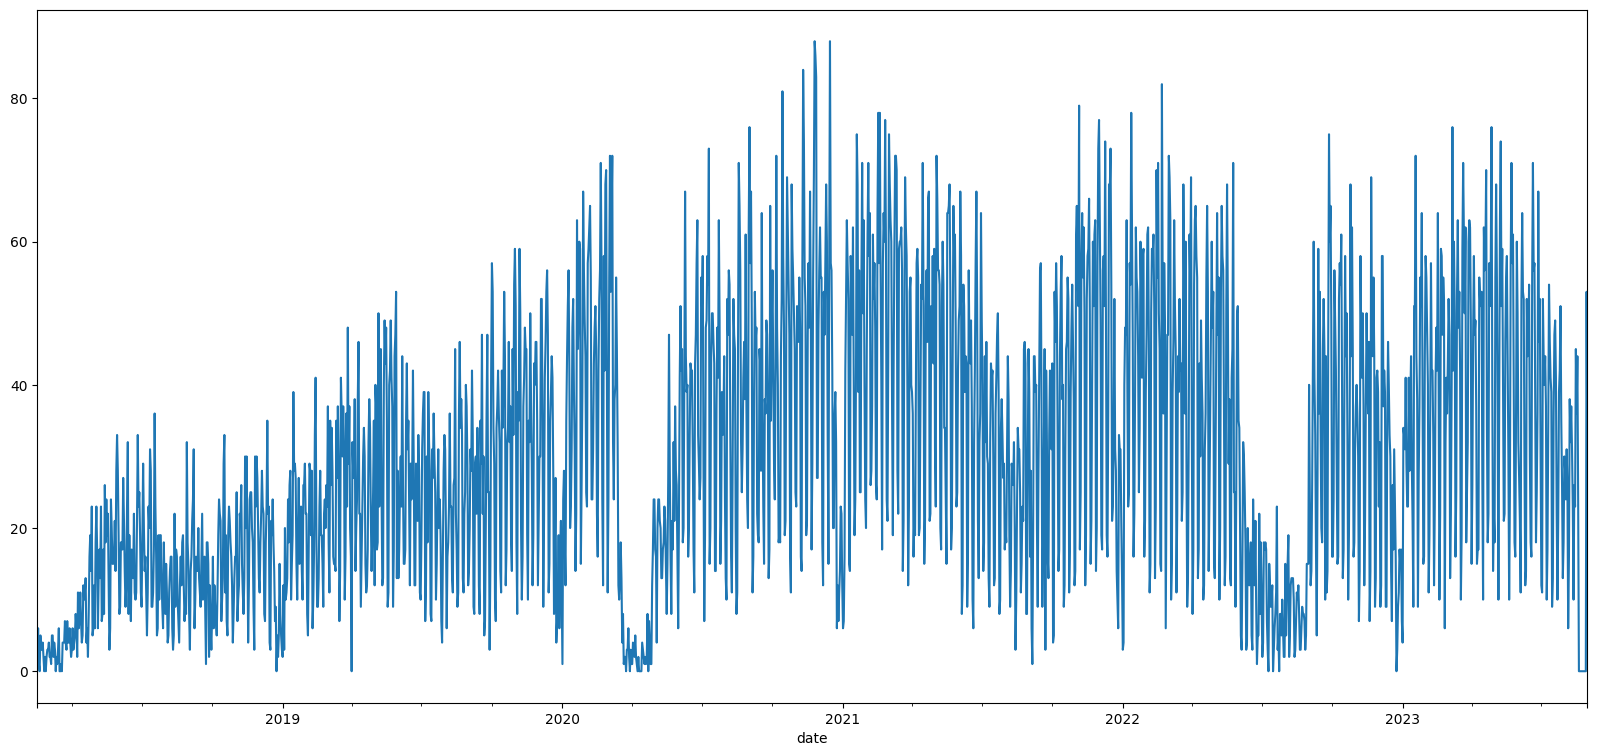

In [5]:
daily_controls = data.resample('d')['station_key'].count()
plt.figure(figsize=(20,9))
daily_controls.plot()

### Taking a decision to cut the beginning

In [7]:
start_date = dt.date(2019, 11, 1)

In [8]:
data = data.loc[start_date:]

<AxesSubplot:xlabel='date'>

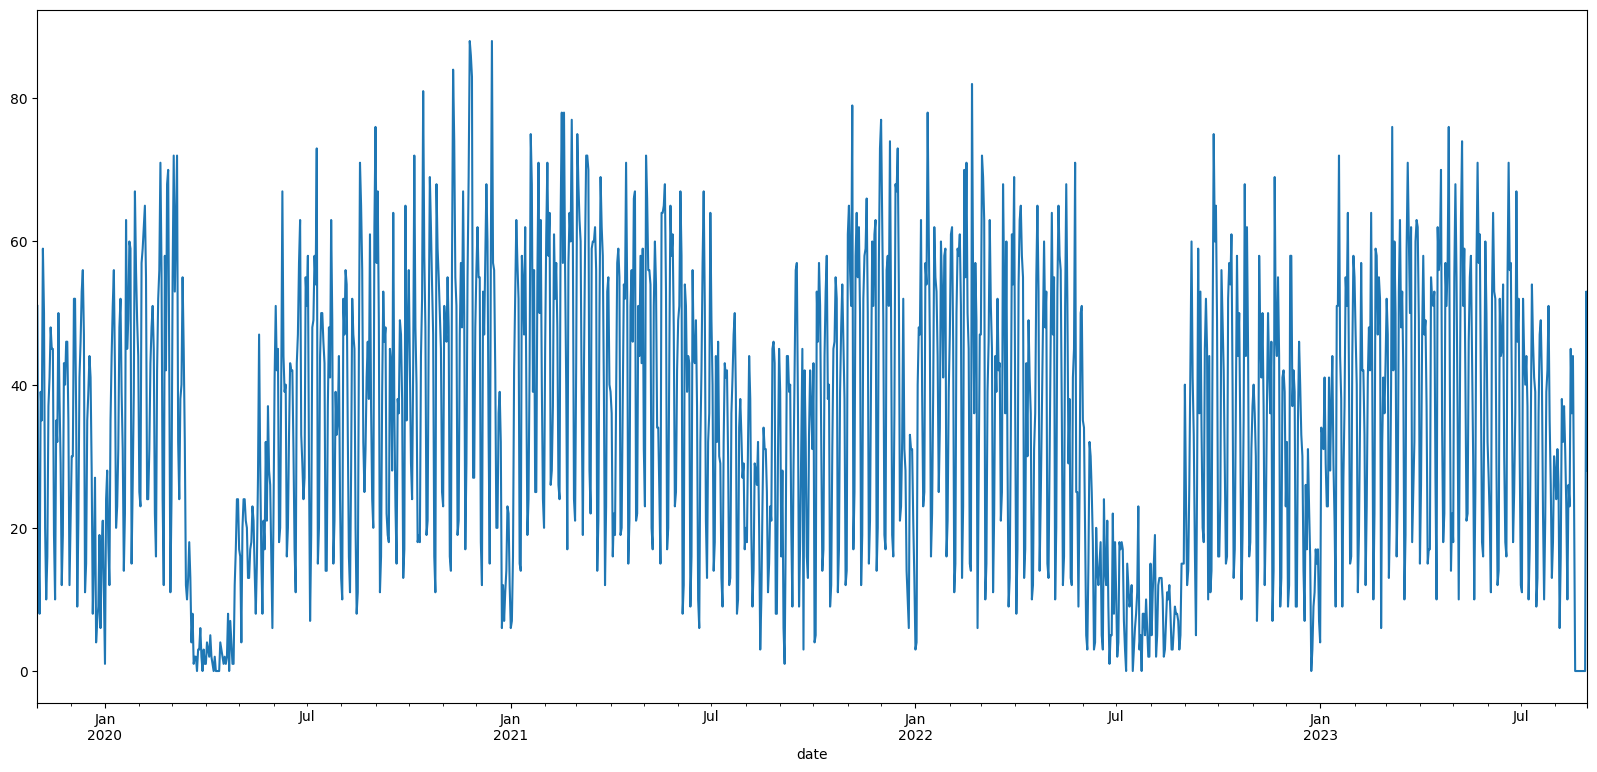

In [9]:
daily_controls = data.resample('d')['station_key'].count()
plt.figure(figsize=(20,9))
daily_controls.plot()

### Creating new time columns for Year, Month, Weekday, Hour

In [10]:
# Year
# Creating a Year column
data["year"] = data.index
data["year"] = pd.to_datetime(data["year"])
data["year"] = data["year"].dt.year

# Months
# Creating a Month column
data["month"] = data.index
data["month"] = pd.to_datetime(data["month"])
data["month"] = data["month"].dt.month
# Naming the months
"""months = {
    1: "January", 2: "February", 3: "March", 
    4: "April", 5: "May", 6: "June", 7: "July", 
    8: "August", 9: "September", 10: "October", 
    11: "November", 12: "December"
}
# Applying the naming
data["month"] = data["month"].map(months)"""

# Weekdays
# Creating a Weekday column
data["weekday"] = data.index
data["weekday"] = pd.to_datetime(data["weekday"])
data["weekday"] = data["weekday"].dt.weekday
# Naming the weekdays
"""weekdays = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"}
# Applying the naming
data["weekday"] = data["weekday"].map(weekdays)"""

# Hours of the day
data["hour"] = data.index
data["hour"] = pd.to_datetime(data["hour"])
data["hour"] = data["hour"].dt.hour

In [11]:
def get_part_of_day(h):
    return ("morning" if 6 <= h <= 11
        else "afternoon" if 12 <= h <= 17
        else "evening" if 18 <= h <= 22
        else "night")

def get_part_of_day_num(h):
    return (1 if 6 <= h <= 11
        else 2 if 12 <= h <= 17
        else 3 if 18 <= h <= 22
        else 4)

In [12]:
# useless for modelling, but useful for visualization! Will drop later on
data["time of day"] = data["hour"].map(get_part_of_day)

In [13]:
#data["time of day num"] = data["hour"].map(get_part_of_day_num)

### Encoding Cyclical Features

In [14]:
data['hour_sin'] = np.sin(2 * np.pi * data['hour']/24.0)
data['hour_cos'] = np.cos(2 * np.pi * data['hour']/24.0)

data['weekday_sin'] = np.sin(2 * np.pi * data['weekday']/7.0)
data['weekday_cos'] = np.cos(2 * np.pi * data['weekday']/7.0)

data['month_sin'] = np.sin(2 * np.pi * data['month']/12.0)
data['month_cos'] = np.cos(2 * np.pi * data['month']/12.0)

### Adding Holidays

In [15]:
!pip install holidays

In [16]:
import holidays

In [17]:
de_holiday_list = []
for holiday in holidays.Germany(years=[2018, 2019, 2020, 2021, 2022, 2023, 2024]).items():
    de_holiday_list.append(holiday)

de_holidays_df = pd.DataFrame(de_holiday_list, columns=["date", "holiday"])
de_holidays_df['date'] = pd.to_datetime(de_holidays_df['date'])
#de_holidays_df.set_index('date', inplace=True)
de_holidays_df["date"].dt.date
#de_holidays_df = de_holidays_df.index.date
#holidays = list(de_holidays_df.index.date)

0     2018-01-01
1     2018-03-30
2     2018-04-02
3     2018-05-01
4     2018-05-10
         ...    
58    2024-05-09
59    2024-05-20
60    2024-10-03
61    2024-12-25
62    2024-12-26
Name: date, Length: 63, dtype: object

In [18]:
de_holidays_df["date"].dt.date

0     2018-01-01
1     2018-03-30
2     2018-04-02
3     2018-05-01
4     2018-05-10
         ...    
58    2024-05-09
59    2024-05-20
60    2024-10-03
61    2024-12-25
62    2024-12-26
Name: date, Length: 63, dtype: object

In [19]:
holiday_arr = data.index.date

In [20]:
str_date = list(map(str, list(holiday_arr)))

In [21]:
holiday_str = list(map(str, list(de_holidays_df["date"].dt.date)))

In [22]:
def find_holiday(date: datetime):
    date_str = str(date.date())
    if date_str in holiday_str:
        return 1
    else: 
        return 0

In [23]:
data['holiday'] = data.index.map(find_holiday)

### Adding Lockdowns

https://de.wikipedia.org/wiki/COVID-19-Pandemie_in_Berlin#:~:text=Am%2023.,diese%20auf%20Landesebene%20beschlossen%20wurden.

Am 23. März 2020 wurden, bis auf Lebensmittel- und einige andere Geschäfte, alle Geschäfte geschlossen. Einzelne Bezirke Berlins erließen zu Beginn teilweise Beschränkungen, bevor diese auf Landesebene beschlossen wurden.

Am 27. April 2021 beschloss der Berliner Senat „Änderungen der Zweiten SARS-CoV-2 Infektionsschutzmaßnahmenverordnung“. 

https://www.wiwo.de/politik/deutschland/corona-lockdown-so-ist-der-zweite-lockdown-in-deutschland-verlaufen/27076474.html
(for first and second lockdown)

In [24]:
import datetime

In [25]:
covid_lockdown1_start = datetime.date(2020, 3, 23)
covid_lockdown1_end = datetime.date(2020, 6, 15)

covid_lockdown2_start = datetime.date(2020, 10, 2)
covid_lockdown2_end = datetime.date(2021, 4, 27)

In [26]:
data["covid"] = data.index.date


In [27]:
def covid_lockdown(some_day):
    if (some_day >= covid_lockdown1_start) & (some_day <= covid_lockdown1_end):
        return 1
    elif (some_day >= covid_lockdown2_start) & (some_day <= covid_lockdown2_end):
        return 1
    return 0
    

In [28]:
data["covid"] = data["covid"].map(covid_lockdown)

In [29]:
data["covid"].value_counts()

0    38086
1    10527
Name: covid, dtype: int64

### Creating bins >  
"n" comes from the shape of data

In [30]:
n_bin = data.resample("h").count().shape[0]

In [31]:
data["bins"] = pd.cut(data.index, bins=n_bin).astype("str")

In [32]:
data['bins'].dtype

dtype('O')

### Loading the dictionary of Bezirke 
(scraped from wikipedia, code for that in the other notebook)

In [33]:
bezirke = {'Charlottenburg-Wilmersdorf': ['Charlottenburg',
  'Wilmersdorf',
  'Schmargendorf',
  'Grunewald',
  'Westend',
  'Charlottenburg-Nord',
  'Halensee'],
 'Friedrichshain-Kreuzberg': ['Friedrichshain', 'Kreuzberg'],
 'Lichtenberg': ['Friedrichsfelde',
  'Karlshorst',
  'Lichtenberg',
  'Falkenberg',
  'Malchow',
  'Wartenberg',
  'Neu-Hohenschönhausen',
  'Alt-Hohenschönhausen',
  'Fennpfuhl',
  'Rummelsburg'],
 'Marzahn-Hellersdorf': ['Marzahn',
  'Biesdorf',
  'Kaulsdorf',
  'Mahlsdorf',
  'Hellersdorf', 'Berlin-Marzahn'],
 'Mitte': ['Mitte',
  'Moabit',
  'Hansaviertel',
  'Tiergarten',
  'Wedding',
  'Gesundbrunnen'],
 'Neukölln': ['Neukölln', 'Britz', 'Buckow', 'Rudow', 'Gropiusstadt'],
 'Pankow': ['Prenzlauer Berg', 'PrenzlauerBerg',
  'Weißensee',
  'Blankenburg',
  'Heinersdorf',
  'Karow',
  'Stadtrandsiedlung Malchow',
  'Pankow',
  'Blankenfelde',
  'Buch',
  'Französisch Buchholz',
  'Niederschönhausen',
  'Rosenthal',
  'Wilhelmsruh'],
 'Reinickendorf': ['Reinickendorf',
  'Tegel',
  'Konradshöhe',
  'Heiligensee',
  'Frohnau',
  'Hermsdorf',
  'Waidmannslust',
  'Lübars',
  'Wittenau',
  'Märkisches Viertel',
  'Borsigwalde'],
 'Spandau': ['Spandau',
  'Haselhorst',
  'Siemensstadt',
  'Staaken',
  'Gatow',
  'Kladow',
  'Hakenfelde',
  'Falkenhagener Feld',
  'Wilhelmstadt'],
 'Steglitz-Zehlendorf': ['Steglitz',
  'Lichterfelde',
  'Lankwitz',
  'Zehlendorf',
  'Dahlem',
  'Nikolassee',
  'Wannsee',
  'Schlachtensee'],
 'Tempelhof-Schöneberg': ['Schöneberg',
  'Friedenau',
  'Tempelhof',
  'Mariendorf',
  'Marienfelde',
  'Lichtenrade'],
 'Treptow-Köpenick': ['Alt-Treptow',
  'Plänterwald',
  'Baumschulenweg',
  'Johannisthal',
  'Niederschöneweide',
  'Altglienicke',
  'Adlershof',
  'Bohnsdorf',
  'Oberschöneweide',
  'Köpenick',
  'Friedrichshagen',
  'Rahnsdorf',
  'Grünau',
  'Müggelheim',
  'Schmöckwitz']}


In [34]:
def area_to_bezirk(some_area):
    for key, values in bezirke.items():
        if some_area in values:
            return key
    return "Brandenburg"
    

data["bezirk"] = data["area"].map(area_to_bezirk)

In [35]:
# Check if all is good
data[data["bezirk"].isna()]["area"].unique()

array([], dtype=object)

### Splitting the dataset

In [36]:
train_size = 0.7
index = round(train_size*data.shape[0])

data_train = data.iloc[:index]
data_test = data.iloc[index:]

### Count Matrix

In [37]:
count_matrix_train = data_train.groupby(["bezirk", "bins"])["station_key"].count().unstack().fillna(0)
count_matrix_test = data_test.groupby(["bezirk", "bins"])["station_key"].count().unstack().fillna(0)


In [38]:
def get_cluster_count(bezirk, time_bin, timestep_shift, count_matrix):
    return count_matrix.shift(periods = timestep_shift, axis = 1)[time_bin][bezirk]

In [39]:
#count_matrix_matrix_train.shift(periods = 0, axis = 1)

In [40]:
def add_clusters_count(df, count_matrix):
    df["target"] = df.apply(lambda df: get_cluster_count(df["bezirk"], df["bins"], -1, count_matrix), axis = 1)
    df["local_0"] = df.apply(lambda df: get_cluster_count(df["bezirk"], df["bins"], 0, count_matrix), axis = 1)
    df["local_1"] = df.apply(lambda df: get_cluster_count(df["bezirk"], df["bins"], 1, count_matrix), axis = 1)
    df["local_2"] = df.apply(lambda df: get_cluster_count(df["bezirk"], df["bins"], 2, count_matrix), axis = 1)
    return df

In [41]:
df_train = add_clusters_count(data_train, count_matrix_train).dropna()
df_test = add_clusters_count(data_test, count_matrix_test).dropna()


/var/folders/13/cyjcpcpx6zx62lkt8r16y6dh0000gn/T/ipykernel_12270/1294894659.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["target"] = df.apply(lambda df: get_cluster_count(df["bezirk"], df["bins"], -1, count_matrix), axis = 1)
/var/folders/13/cyjcpcpx6zx62lkt8r16y6dh0000gn/T/ipykernel_12270/1294894659.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["local_0"] = df.apply(lambda df: get_cluster_count(df["bezirk"], df["bins"], 0, count_matrix), axis = 1)
/var/folders/13/cyjcpcpx6zx62lkt8r16y6dh

In [42]:
print("Unique targets (train) =", df_train["target"].nunique())
print("Unique Local 0 (train) =", df_train["local_0"].nunique())
print("Unique Local 1 (train) =", df_train["local_1"].nunique())
print("Unique Local 2 (train) =", df_train["local_2"].nunique())

print("Unique targets (test) =", df_test["target"].nunique())
print("Unique Local 0 (test) =", df_test["local_0"].nunique())
print("Unique Local 1 (test) =", df_test["local_1"].nunique())
print("Unique Local 2 (test) =", df_test["local_2"].nunique())

Unique targets (train) = 12
Unique Local 0 (train) = 11
Unique Local 1 (train) = 12
Unique Local 2 (train) = 12
Unique targets (test) = 9
Unique Local 0 (test) = 8
Unique Local 1 (test) = 9
Unique Local 2 (test) = 9


### OneHotEncoding Bezirke

In [43]:
encoder=OneHotEncoder(sparse = False)
encoder.fit(df_train[["bezirk"]])
df_train[encoder.get_feature_names_out()] = encoder.transform(df_train[["bezirk"]])
df_test[encoder.get_feature_names_out()] = encoder.transform(df_test[["bezirk"]])

/Users/annushkak/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/var/folders/13/cyjcpcpx6zx62lkt8r16y6dh0000gn/T/ipykernel_12270/3194366261.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[encoder.get_feature_names_out()] = encoder.transform(df_train[["bezirk"]])
/var/folders/13/cyjcpcpx6zx62lkt8r16y6dh0000gn/T/ipykernel_12270/3194366261.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [44]:
df_train.columns

Index(['station_key', 'text', 'station name', 'lines', 'area', 'latitude',
       'longitude', 'year', 'month', 'weekday', 'hour', 'time of day',
       'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'month_sin',
       'month_cos', 'holiday', 'covid', 'bins', 'bezirk', 'target', 'local_0',
       'local_1', 'local_2', 'bezirk_Brandenburg',
       'bezirk_Charlottenburg-Wilmersdorf', 'bezirk_Friedrichshain-Kreuzberg',
       'bezirk_Lichtenberg', 'bezirk_Marzahn-Hellersdorf', 'bezirk_Mitte',
       'bezirk_Neukölln', 'bezirk_Pankow', 'bezirk_Reinickendorf',
       'bezirk_Spandau', 'bezirk_Steglitz-Zehlendorf',
       'bezirk_Tempelhof-Schöneberg', 'bezirk_Treptow-Köpenick'],
      dtype='object')

In [45]:
print("duplicated in train =", df_train.duplicated(subset=["bezirk", "bins"]).sum())
print("duplicated in test =", df_test.duplicated(subset=["bezirk", "bins"]).sum())

duplicated in train = 9803
duplicated in test = 3827


In [46]:
df_train = df_train.drop_duplicates(subset=["bezirk", "bins"])
df_test = df_test.drop_duplicates(subset=["bezirk", "bins"])

In [47]:
def mapping(some_y):
    if some_y == 0:
        return 0
    return 1

In [48]:
#X_train = df_train.drop(columns = ['station_key', 'text', 'station name', 'lines', 'area', 'target', 'bins', 'bezirk'])
#y_train = df_train['target'].map(mapping)
#X_test = df_test.drop(columns = ['station_key', 'text', 'station name', 'lines', 'area', 'target', 'bins', 'bezirk'])
#y_test = df_test['target'].map(mapping)

In [49]:
# Also dropped 'hour', 'time of day'
X_train = df_train.drop(columns = ['station_key', 'text', 'station name', 'lines', 'area', 'target', 'bins', 'bezirk', 'month', 'weekday', 'hour', 'time of day',])
y_train = df_train['target'].map(mapping)
X_test = df_test.drop(columns = ['station_key', 'text', 'station name', 'lines', 'area', 'target', 'bins', 'bezirk', 'month', 'weekday', 'hour', 'time of day',])
y_test = df_test['target'].map(mapping)

### RandomForestClassifier (Recall = 0.698)

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import recall_score
import numpy as np
import scipy.stats as stats

In [51]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [52]:
pd.DataFrame(X_train.columns, rf_model.feature_importances_).sort_index()

,0
0.001184,bezirk_Brandenburg
0.001514,bezirk_Lichtenberg
0.001542,bezirk_Marzahn-Hellersdorf
0.001827,bezirk_Spandau
0.002345,bezirk_Reinickendorf
0.002847,bezirk_Steglitz-Zehlendorf
0.003923,bezirk_Treptow-Köpenick
0.004180,holiday
0.004206,bezirk_Tempelhof-Schöneberg
0.004374,bezirk_Charlottenburg-Wilmersdorf


In [53]:
y_train.value_counts()

0    14206
1    10012
Name: target, dtype: int64

In [54]:
print("train score =", rf_model.score(X_train, y_train))
print("test score =", rf_model.score(X_test, y_test))

train score = 0.9974399207201256
test score = 0.6821864233168824


In [55]:
parameters = {'max_depth':[10, 11, 12], 'min_samples_split':[4, 5, 6]}
rflf = GridSearchCV(rf_model, parameters, scoring='recall', n_jobs=-1)
rflf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 11, 12],
                         'min_samples_split': [4, 5, 6]},
             scoring='recall')

In [56]:
rflf.best_params_

{'max_depth': 12, 'min_samples_split': 6}

In [57]:
rflf.best_estimator_.score(X_test, y_test) # 0.698 not too bad

0.6982959307198063

In [59]:
best_model = rflf.best_estimator_

In [66]:
X_train.iloc[1]

latitude                               52.434722
longitude                              13.541389
year                                 2019.000000
hour_sin                                0.866025
hour_cos                               -0.500000
weekday_sin                            -0.433884
weekday_cos                            -0.900969
month_sin                              -0.500000
month_cos                               0.866025
holiday                                 0.000000
covid                                   0.000000
local_0                                 1.000000
local_1                                 0.000000
local_2                                 1.000000
bezirk_Brandenburg                      0.000000
bezirk_Charlottenburg-Wilmersdorf       0.000000
bezirk_Friedrichshain-Kreuzberg         0.000000
bezirk_Lichtenberg                      0.000000
bezirk_Marzahn-Hellersdorf              0.000000
bezirk_Mitte                            0.000000
bezirk_Neukölln     

In [60]:
import pickle

pickle.dump(best_model, open('model.pkl', 'wb'))

In [72]:
X_test

,latitude,longitude,year,hour_sin,hour_cos,weekday_sin,weekday_cos,month_sin,month_cos,holiday,...,bezirk_Lichtenberg,bezirk_Marzahn-Hellersdorf,bezirk_Mitte,bezirk_Neukölln,bezirk_Pankow,bezirk_Reinickendorf,bezirk_Spandau,bezirk_Steglitz-Zehlendorf,bezirk_Tempelhof-Schöneberg,bezirk_Treptow-Köpenick
date,,,,,,,,,,,,,,,,,,,,,
2022-05-11 13:34:00,52.496389,13.523333,2022,-0.258819,-0.965926,0.974928,-0.222521,0.500000,-0.866025,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-05-11 14:20:00,52.505833,13.390556,2022,-0.500000,-0.866025,0.974928,-0.222521,0.500000,-0.866025,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-05-11 15:07:00,52.515833,13.307500,2022,-0.707107,-0.707107,0.974928,-0.222521,0.500000,-0.866025,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-05-11 15:24:00,52.499167,13.418056,2022,-0.707107,-0.707107,0.974928,-0.222521,0.500000,-0.866025,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-05-11 15:39:00,52.512500,13.575000,2022,-0.707107,-0.707107,0.974928,-0.222521,0.500000,-0.866025,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-30 09:28:00,52.505833,13.390556,2023,0.707107,-0.707107,0.974928,-0.222521,-0.866025,-0.500000,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-08-30 09:29:00,52.529444,13.454722,2023,0.707107,-0.707107,0.974928,-0.222521,-0.866025,-0.500000,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2023-08-30 09:47:00,52.512500,13.575000,2023,0.707107,-0.707107,0.974928,-0.222521,-0.866025,-0.500000,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
X_test.iloc[3]

latitude                               52.499167
longitude                              13.418056
year                                 2022.000000
hour_sin                               -0.707107
hour_cos                               -0.707107
weekday_sin                             0.974928
weekday_cos                            -0.222521
month_sin                               0.500000
month_cos                              -0.866025
holiday                                 0.000000
covid                                   0.000000
local_0                                 1.000000
local_1                                 0.000000
local_2                                 1.000000
bezirk_Brandenburg                      0.000000
bezirk_Charlottenburg-Wilmersdorf       0.000000
bezirk_Friedrichshain-Kreuzberg         1.000000
bezirk_Lichtenberg                      0.000000
bezirk_Marzahn-Hellersdorf              0.000000
bezirk_Mitte                            0.000000
bezirk_Neukölln     

In [65]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
# Maximum number of levels in tree
max_depth = stats.randint(1,20)
# Minimum number of samples required to split a node
min_samples_split = stats.randint(1,7)
# Minimum number of samples required at each leaf node
min_samples_leaf = stats.randint(1,7)
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [66]:
param_grid

{'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72, 80],
 'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen at 0x17718b130>,
 'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen at 0x17718a9e0>,
 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen at 0x17718aad0>,
 'bootstrap': [True, False]}

In [67]:
from sklearn.model_selection import RandomizedSearchCV

rf_RandomGrid = RandomizedSearchCV(estimator = rf_model, 
                                   param_distributions = param_grid, 
                                   cv = 5, verbose=2, n_iter=100, 
                                   n_jobs = 4, scoring = "recall")

In [68]:
rf_RandomGrid.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/annushkak/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
75 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/annushkak/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/annushkak/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/Users/annushkak/.pyenv/versions/3.10.6/envs/lewagon/lib/p

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x17718b130>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x17718aad0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x17718a9e0>,
                                        'n_estimators': [10, 17, 25, 33, 41, 48,
                                                         56, 64, 72, 80]},
                   scoring='recall', verbose=2)

In [69]:
rf_RandomGrid.best_params_

{'bootstrap': True,
 'max_depth': 17,
 'min_samples_leaf': 5,
 'min_samples_split': 5,
 'n_estimators': 25}

In [70]:
rf_RandomGrid.best_estimator_.score(X_test, y_test)

0.6938756515264334

In [71]:
y_test.value_counts(normalize=True)

0    0.613273
1    0.386727
Name: target, dtype: float64

In [ ]:
## random search for SVM

### KNeighborsClassifier (Recall = 0.666)

In [72]:
from sklearn.neighbors import KNeighborsClassifier

In [93]:
kn_model = KNeighborsClassifier()
parameters = {'n_neighbors':[5, 6, 7, 8, 9, 10, 11, 12, 13]}
kn = GridSearchCV(kn_model, parameters, scoring='recall', n_jobs=-1)
kn.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13]},
             scoring='recall')

In [94]:
kn.best_params_

{'n_neighbors': 9}

In [95]:
kn.best_estimator_.score(X_test, y_test)

0.6667907669396873

In [68]:
import sklearn
sklearn.__version__

'1.3.0'

In [69]:
!pip install scikit-learn==1.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 3.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.0
    Uninstalling scikit-learn-1.3.0:
      Successfully uninstalled scikit-learn-1.3.0


### SVC (Recall = 0.632)

In [96]:
parameters = {'kernel':['rbf'], 'C':[10, 100], 'gamma': [0.001,0.01,0.1]}
svc_model = svm.SVC()
svc_grid = GridSearchCV(svc_model, parameters, scoring='recall', n_jobs=-1)
svc_grid.fit(X_train, y_train)

742:	learn: 0.5290858	total: 4.51s	remaining: 1.56s
743:	learn: 0.5290372	total: 4.51s	remaining: 1.55s
744:	learn: 0.5290288	total: 4.52s	remaining: 1.55s
745:	learn: 0.5290202	total: 4.52s	remaining: 1.54s
746:	learn: 0.5289806	total: 4.53s	remaining: 1.53s
747:	learn: 0.5289806	total: 4.54s	remaining: 1.53s
748:	learn: 0.5289709	total: 4.55s	remaining: 1.52s
749:	learn: 0.5289479	total: 4.55s	remaining: 1.52s
750:	learn: 0.5289335	total: 4.56s	remaining: 1.51s
751:	learn: 0.5288770	total: 4.56s	remaining: 1.5s
752:	learn: 0.5288253	total: 4.57s	remaining: 1.5s
753:	learn: 0.5287581	total: 4.58s	remaining: 1.49s
754:	learn: 0.5287441	total: 4.58s	remaining: 1.49s
755:	learn: 0.5287239	total: 4.59s	remaining: 1.48s
756:	learn: 0.5286822	total: 4.59s	remaining: 1.47s
757:	learn: 0.5286347	total: 4.6s	remaining: 1.47s
758:	learn: 0.5286027	total: 4.6s	remaining: 1.46s
759:	learn: 0.5285926	total: 4.61s	remaining: 1.46s
760:	learn: 0.5285926	total: 4.62s	remaining: 1.45s
761:	learn: 0.52

743:	learn: 0.5331690	total: 4.49s	remaining: 1.54s
744:	learn: 0.5331214	total: 4.49s	remaining: 1.54s
745:	learn: 0.5331015	total: 4.5s	remaining: 1.53s
746:	learn: 0.5330945	total: 4.51s	remaining: 1.53s
747:	learn: 0.5330859	total: 4.51s	remaining: 1.52s
748:	learn: 0.5330685	total: 4.52s	remaining: 1.51s
749:	learn: 0.5330405	total: 4.52s	remaining: 1.51s
750:	learn: 0.5329960	total: 4.53s	remaining: 1.5s
751:	learn: 0.5329659	total: 4.53s	remaining: 1.5s
752:	learn: 0.5329070	total: 4.54s	remaining: 1.49s
753:	learn: 0.5328974	total: 4.54s	remaining: 1.48s
754:	learn: 0.5328908	total: 4.55s	remaining: 1.48s
755:	learn: 0.5328406	total: 4.56s	remaining: 1.47s
756:	learn: 0.5328179	total: 4.56s	remaining: 1.46s
757:	learn: 0.5328005	total: 4.57s	remaining: 1.46s
758:	learn: 0.5327894	total: 4.58s	remaining: 1.45s
759:	learn: 0.5327158	total: 4.58s	remaining: 1.45s
760:	learn: 0.5326884	total: 4.59s	remaining: 1.44s
761:	learn: 0.5326353	total: 4.59s	remaining: 1.44s
762:	learn: 0.5

741:	learn: 0.5205271	total: 4.44s	remaining: 1.54s
742:	learn: 0.5205148	total: 4.44s	remaining: 1.54s
743:	learn: 0.5205132	total: 4.45s	remaining: 1.53s
744:	learn: 0.5205069	total: 4.46s	remaining: 1.52s
745:	learn: 0.5204874	total: 4.46s	remaining: 1.52s
746:	learn: 0.5203962	total: 4.46s	remaining: 1.51s
747:	learn: 0.5203688	total: 4.47s	remaining: 1.51s
748:	learn: 0.5203522	total: 4.48s	remaining: 1.5s
749:	learn: 0.5203362	total: 4.48s	remaining: 1.49s
750:	learn: 0.5202748	total: 4.49s	remaining: 1.49s
751:	learn: 0.5202638	total: 4.5s	remaining: 1.48s
752:	learn: 0.5202584	total: 4.5s	remaining: 1.48s
753:	learn: 0.5202554	total: 4.51s	remaining: 1.47s
754:	learn: 0.5202296	total: 4.51s	remaining: 1.47s
755:	learn: 0.5202134	total: 4.52s	remaining: 1.46s
756:	learn: 0.5201987	total: 4.52s	remaining: 1.45s
757:	learn: 0.5201768	total: 4.53s	remaining: 1.45s
758:	learn: 0.5201717	total: 4.54s	remaining: 1.44s
759:	learn: 0.5201046	total: 4.55s	remaining: 1.44s
760:	learn: 0.5

742:	learn: 0.5298326	total: 4.85s	remaining: 1.68s
743:	learn: 0.5297852	total: 4.86s	remaining: 1.67s
744:	learn: 0.5297257	total: 4.87s	remaining: 1.67s
745:	learn: 0.5297044	total: 4.88s	remaining: 1.66s
746:	learn: 0.5296971	total: 4.88s	remaining: 1.65s
747:	learn: 0.5296854	total: 4.89s	remaining: 1.65s
748:	learn: 0.5296253	total: 4.89s	remaining: 1.64s
749:	learn: 0.5295808	total: 4.9s	remaining: 1.63s
750:	learn: 0.5295670	total: 4.91s	remaining: 1.63s
751:	learn: 0.5295447	total: 4.91s	remaining: 1.62s
752:	learn: 0.5294836	total: 4.92s	remaining: 1.61s
753:	learn: 0.5294503	total: 4.92s	remaining: 1.6s
754:	learn: 0.5294376	total: 4.93s	remaining: 1.6s
755:	learn: 0.5294185	total: 4.93s	remaining: 1.59s
756:	learn: 0.5293673	total: 4.94s	remaining: 1.58s
757:	learn: 0.5293301	total: 4.94s	remaining: 1.58s
758:	learn: 0.5292980	total: 4.95s	remaining: 1.57s
759:	learn: 0.5292887	total: 4.95s	remaining: 1.56s
760:	learn: 0.5292624	total: 4.96s	remaining: 1.56s
761:	learn: 0.5

GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [10, 100], 'gamma': [0.001, 0.01, 0.1],
                         'kernel': ['rbf']},
             scoring='recall')

In [97]:
svc_grid.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

In [98]:
svc_grid.best_estimator_.score(X_test, y_test)

0.6867088607594937

In [100]:
# Random Search

In [101]:
param_grid = {"C": stats.uniform(5, 15),
             "gamma": stats.uniform(0.1, 1)}

svc_RandomGrid = RandomizedSearchCV(estimator = svc_model, 
                                   param_distributions = param_grid, #### SVC Param Grid!
                                   cv = 5, n_iter=50, ##
                                   n_jobs = 4, scoring = "recall")

svc_RandomGrid.fit(X_train, y_train)

/Users/annushkak/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=SVC(), n_iter=50, n_jobs=4,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x2db048340>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1772c0220>},
                   scoring='recall')

In [102]:
svc_RandomGrid.best_params_

{'C': 5.381860396251177, 'gamma': 0.5548480423280919}

In [103]:
svc_RandomGrid.best_estimator_.score(X_test, y_test)

0.6322598659717051

### CatBoostClassifier (Recall = 0.516)

In [86]:
# !pip install catboost

In [82]:
cat_model = CatBoostClassifier()
cat_model.fit(X_train, y_train)

cat_train_score = recall_score(y_train, cat_model.predict(X_train))
cat_test_score = recall_score(y_test, cat_model.predict(X_test))

print(f"Recall Train score for CatBoost: {cat_train_score}")
print(f"Recall Test score for CatBoost: {cat_test_score}")

Learning rate set to 0.040173
0:	learn: 0.6848110	total: 65.9ms	remaining: 1m 5s
1:	learn: 0.6773470	total: 72.1ms	remaining: 36s
2:	learn: 0.6702234	total: 78.2ms	remaining: 26s
3:	learn: 0.6639299	total: 84ms	remaining: 20.9s
4:	learn: 0.6575417	total: 89.7ms	remaining: 17.8s
5:	learn: 0.6521945	total: 95ms	remaining: 15.7s
6:	learn: 0.6475741	total: 98.3ms	remaining: 13.9s
7:	learn: 0.6427525	total: 102ms	remaining: 12.7s
8:	learn: 0.6380397	total: 106ms	remaining: 11.7s
9:	learn: 0.6343836	total: 110ms	remaining: 10.9s
10:	learn: 0.6306752	total: 114ms	remaining: 10.2s
11:	learn: 0.6274884	total: 118ms	remaining: 9.67s
12:	learn: 0.6242619	total: 121ms	remaining: 9.21s
13:	learn: 0.6214748	total: 125ms	remaining: 8.83s
14:	learn: 0.6184750	total: 129ms	remaining: 8.49s
15:	learn: 0.6157844	total: 134ms	remaining: 8.21s
16:	learn: 0.6131475	total: 137ms	remaining: 7.95s
17:	learn: 0.6112651	total: 142ms	remaining: 7.75s
18:	learn: 0.6092444	total: 146ms	remaining: 7.55s
19:	learn: 0

183:	learn: 0.5595512	total: 798ms	remaining: 3.54s
184:	learn: 0.5594743	total: 802ms	remaining: 3.53s
185:	learn: 0.5593762	total: 805ms	remaining: 3.52s
186:	learn: 0.5593485	total: 809ms	remaining: 3.52s
187:	learn: 0.5592405	total: 813ms	remaining: 3.51s
188:	learn: 0.5591549	total: 818ms	remaining: 3.51s
189:	learn: 0.5590265	total: 822ms	remaining: 3.5s
190:	learn: 0.5588851	total: 826ms	remaining: 3.5s
191:	learn: 0.5587801	total: 830ms	remaining: 3.49s
192:	learn: 0.5586927	total: 834ms	remaining: 3.49s
193:	learn: 0.5586102	total: 838ms	remaining: 3.48s
194:	learn: 0.5585125	total: 842ms	remaining: 3.48s
195:	learn: 0.5584303	total: 847ms	remaining: 3.47s
196:	learn: 0.5583160	total: 851ms	remaining: 3.47s
197:	learn: 0.5582227	total: 855ms	remaining: 3.46s
198:	learn: 0.5581182	total: 859ms	remaining: 3.46s
199:	learn: 0.5580652	total: 863ms	remaining: 3.45s
200:	learn: 0.5579477	total: 867ms	remaining: 3.45s
201:	learn: 0.5578949	total: 871ms	remaining: 3.44s
202:	learn: 0.

386:	learn: 0.5438867	total: 1.6s	remaining: 2.53s
387:	learn: 0.5438085	total: 1.6s	remaining: 2.53s
388:	learn: 0.5437570	total: 1.61s	remaining: 2.52s
389:	learn: 0.5436914	total: 1.61s	remaining: 2.52s
390:	learn: 0.5435826	total: 1.61s	remaining: 2.52s
391:	learn: 0.5435069	total: 1.62s	remaining: 2.51s
392:	learn: 0.5434266	total: 1.62s	remaining: 2.51s
393:	learn: 0.5433936	total: 1.63s	remaining: 2.5s
394:	learn: 0.5433717	total: 1.63s	remaining: 2.5s
395:	learn: 0.5432736	total: 1.64s	remaining: 2.49s
396:	learn: 0.5432061	total: 1.64s	remaining: 2.49s
397:	learn: 0.5431989	total: 1.64s	remaining: 2.48s
398:	learn: 0.5431403	total: 1.65s	remaining: 2.48s
399:	learn: 0.5430366	total: 1.65s	remaining: 2.48s
400:	learn: 0.5429595	total: 1.65s	remaining: 2.47s
401:	learn: 0.5428604	total: 1.66s	remaining: 2.47s
402:	learn: 0.5427602	total: 1.66s	remaining: 2.46s
403:	learn: 0.5427252	total: 1.67s	remaining: 2.46s
404:	learn: 0.5426133	total: 1.67s	remaining: 2.45s
405:	learn: 0.54

590:	learn: 0.5308328	total: 2.4s	remaining: 1.66s
591:	learn: 0.5307426	total: 2.41s	remaining: 1.66s
592:	learn: 0.5307306	total: 2.41s	remaining: 1.66s
593:	learn: 0.5306758	total: 2.42s	remaining: 1.65s
594:	learn: 0.5305863	total: 2.42s	remaining: 1.65s
595:	learn: 0.5304927	total: 2.43s	remaining: 1.64s
596:	learn: 0.5304363	total: 2.43s	remaining: 1.64s
597:	learn: 0.5303717	total: 2.43s	remaining: 1.64s
598:	learn: 0.5303141	total: 2.44s	remaining: 1.63s
599:	learn: 0.5302541	total: 2.44s	remaining: 1.63s
600:	learn: 0.5302446	total: 2.44s	remaining: 1.62s
601:	learn: 0.5301873	total: 2.45s	remaining: 1.62s
602:	learn: 0.5301833	total: 2.45s	remaining: 1.61s
603:	learn: 0.5301665	total: 2.46s	remaining: 1.61s
604:	learn: 0.5301140	total: 2.46s	remaining: 1.61s
605:	learn: 0.5300288	total: 2.46s	remaining: 1.6s
606:	learn: 0.5299570	total: 2.47s	remaining: 1.6s
607:	learn: 0.5298929	total: 2.47s	remaining: 1.59s
608:	learn: 0.5298261	total: 2.48s	remaining: 1.59s
609:	learn: 0.5

795:	learn: 0.5193968	total: 3.21s	remaining: 822ms
796:	learn: 0.5193090	total: 3.21s	remaining: 818ms
797:	learn: 0.5192600	total: 3.22s	remaining: 814ms
798:	learn: 0.5192113	total: 3.22s	remaining: 810ms
799:	learn: 0.5191548	total: 3.23s	remaining: 806ms
800:	learn: 0.5191298	total: 3.23s	remaining: 802ms
801:	learn: 0.5190842	total: 3.23s	remaining: 798ms
802:	learn: 0.5190619	total: 3.24s	remaining: 794ms
803:	learn: 0.5189938	total: 3.24s	remaining: 790ms
804:	learn: 0.5189171	total: 3.24s	remaining: 786ms
805:	learn: 0.5188641	total: 3.25s	remaining: 782ms
806:	learn: 0.5187909	total: 3.25s	remaining: 778ms
807:	learn: 0.5187447	total: 3.25s	remaining: 773ms
808:	learn: 0.5187062	total: 3.26s	remaining: 769ms
809:	learn: 0.5186335	total: 3.26s	remaining: 765ms
810:	learn: 0.5186012	total: 3.27s	remaining: 761ms
811:	learn: 0.5185467	total: 3.27s	remaining: 757ms
812:	learn: 0.5185111	total: 3.27s	remaining: 753ms
813:	learn: 0.5184748	total: 3.28s	remaining: 749ms
814:	learn: 

999:	learn: 0.5088554	total: 4.01s	remaining: 0us
Recall Train score for CatBoost: 0.6012404961984794
Recall Test score for CatBoost: 0.5220216606498195


In [83]:
parameters = {'learning_rate': [0.13, 0.17, 0.2], 'depth': [1, 2, 3]}
cat = GridSearchCV(cat_model, parameters, scoring='recall', n_jobs=-1)
cat.fit(X_train, y_train)

0:	learn: 0.6762346	total: 61.4ms	remaining: 1m 1s
1:	learn: 0.6635260	total: 66.2ms	remaining: 33s
2:	learn: 0.6539870	total: 70.3ms	remaining: 23.4s
3:	learn: 0.6468349	total: 74.6ms	remaining: 18.6s
4:	learn: 0.6414752	total: 78.9ms	remaining: 15.7s
5:	learn: 0.6370531	total: 82.9ms	remaining: 13.7s
6:	learn: 0.6324141	total: 87.4ms	remaining: 12.4s
7:	learn: 0.6293246	total: 91.6ms	remaining: 11.4s
8:	learn: 0.6264873	total: 97.8ms	remaining: 10.8s
9:	learn: 0.6236288	total: 103ms	remaining: 10.2s
10:	learn: 0.6212121	total: 108ms	remaining: 9.67s
11:	learn: 0.6193876	total: 112ms	remaining: 9.26s
12:	learn: 0.6175589	total: 118ms	remaining: 8.95s
13:	learn: 0.6153031	total: 121ms	remaining: 8.55s
14:	learn: 0.6137877	total: 128ms	remaining: 8.37s
15:	learn: 0.6122739	total: 135ms	remaining: 8.31s
16:	learn: 0.6106441	total: 140ms	remaining: 8.1s
17:	learn: 0.6094161	total: 143ms	remaining: 7.82s
18:	learn: 0.6082199	total: 147ms	remaining: 7.58s
19:	learn: 0.6071524	total: 152ms	r

0:	learn: 0.6730872	total: 59.8ms	remaining: 59.7s
1:	learn: 0.6593922	total: 62.3ms	remaining: 31.1s
2:	learn: 0.6500685	total: 65.4ms	remaining: 21.7s
3:	learn: 0.6437520	total: 68.2ms	remaining: 17s
4:	learn: 0.6393743	total: 71.5ms	remaining: 14.2s
5:	learn: 0.6346554	total: 74.6ms	remaining: 12.4s
6:	learn: 0.6297448	total: 78.1ms	remaining: 11.1s
7:	learn: 0.6268581	total: 81.6ms	remaining: 10.1s
8:	learn: 0.6239837	total: 86.1ms	remaining: 9.48s
9:	learn: 0.6217396	total: 90.2ms	remaining: 8.93s
10:	learn: 0.6201340	total: 93.7ms	remaining: 8.42s
11:	learn: 0.6178498	total: 99.3ms	remaining: 8.18s
12:	learn: 0.6158198	total: 104ms	remaining: 7.9s
13:	learn: 0.6132524	total: 109ms	remaining: 7.68s
14:	learn: 0.6117444	total: 113ms	remaining: 7.42s
15:	learn: 0.6103712	total: 116ms	remaining: 7.15s
16:	learn: 0.6090938	total: 122ms	remaining: 7.03s
17:	learn: 0.6079812	total: 127ms	remaining: 6.94s
18:	learn: 0.6062490	total: 131ms	remaining: 6.78s
19:	learn: 0.6051818	total: 135m

0:	learn: 0.6770149	total: 63.9ms	remaining: 1m 3s
1:	learn: 0.6648860	total: 68.9ms	remaining: 34.4s
2:	learn: 0.6557797	total: 74.2ms	remaining: 24.7s
3:	learn: 0.6489495	total: 78.6ms	remaining: 19.6s
4:	learn: 0.6440396	total: 81.9ms	remaining: 16.3s
5:	learn: 0.6403081	total: 85.6ms	remaining: 14.2s
6:	learn: 0.6362867	total: 89.9ms	remaining: 12.7s
7:	learn: 0.6322615	total: 95.9ms	remaining: 11.9s
8:	learn: 0.6294835	total: 103ms	remaining: 11.4s
9:	learn: 0.6271683	total: 108ms	remaining: 10.7s
10:	learn: 0.6246573	total: 112ms	remaining: 10.1s
11:	learn: 0.6229412	total: 116ms	remaining: 9.59s
12:	learn: 0.6210877	total: 126ms	remaining: 9.55s
13:	learn: 0.6186589	total: 137ms	remaining: 9.63s
14:	learn: 0.6170355	total: 147ms	remaining: 9.63s
15:	learn: 0.6155526	total: 163ms	remaining: 10s
16:	learn: 0.6141915	total: 180ms	remaining: 10.4s
17:	learn: 0.6127933	total: 195ms	remaining: 10.6s
18:	learn: 0.6114464	total: 210ms	remaining: 10.8s
19:	learn: 0.6104628	total: 223ms	r

317:	learn: 0.5669122	total: 1.7s	remaining: 3.64s
318:	learn: 0.5669122	total: 1.7s	remaining: 3.63s
319:	learn: 0.5668712	total: 1.71s	remaining: 3.63s
320:	learn: 0.5668523	total: 1.71s	remaining: 3.62s
321:	learn: 0.5668507	total: 1.72s	remaining: 3.62s
322:	learn: 0.5668484	total: 1.72s	remaining: 3.61s
323:	learn: 0.5668395	total: 1.73s	remaining: 3.6s
324:	learn: 0.5668267	total: 1.73s	remaining: 3.59s
325:	learn: 0.5668176	total: 1.74s	remaining: 3.6s
326:	learn: 0.5667969	total: 1.74s	remaining: 3.59s
327:	learn: 0.5667961	total: 1.75s	remaining: 3.59s
328:	learn: 0.5667954	total: 1.76s	remaining: 3.58s
329:	learn: 0.5667902	total: 1.76s	remaining: 3.58s
330:	learn: 0.5667808	total: 1.76s	remaining: 3.57s
331:	learn: 0.5667667	total: 1.77s	remaining: 3.56s
332:	learn: 0.5667513	total: 1.77s	remaining: 3.55s
333:	learn: 0.5667442	total: 1.78s	remaining: 3.55s
334:	learn: 0.5667439	total: 1.79s	remaining: 3.54s
335:	learn: 0.5667439	total: 1.79s	remaining: 3.53s
336:	learn: 0.56

317:	learn: 0.5749798	total: 1.71s	remaining: 3.66s
318:	learn: 0.5749797	total: 1.71s	remaining: 3.65s
319:	learn: 0.5749796	total: 1.71s	remaining: 3.64s
320:	learn: 0.5749796	total: 1.72s	remaining: 3.64s
321:	learn: 0.5749703	total: 1.73s	remaining: 3.63s
322:	learn: 0.5749700	total: 1.73s	remaining: 3.63s
323:	learn: 0.5749681	total: 1.74s	remaining: 3.62s
324:	learn: 0.5749599	total: 1.74s	remaining: 3.62s
325:	learn: 0.5749454	total: 1.75s	remaining: 3.62s
326:	learn: 0.5749414	total: 1.75s	remaining: 3.61s
327:	learn: 0.5749314	total: 1.75s	remaining: 3.6s
328:	learn: 0.5749196	total: 1.76s	remaining: 3.59s
329:	learn: 0.5749130	total: 1.76s	remaining: 3.58s
330:	learn: 0.5749129	total: 1.77s	remaining: 3.58s
331:	learn: 0.5749057	total: 1.77s	remaining: 3.57s
332:	learn: 0.5749057	total: 1.78s	remaining: 3.56s
333:	learn: 0.5748991	total: 1.78s	remaining: 3.55s
334:	learn: 0.5748765	total: 1.78s	remaining: 3.54s
335:	learn: 0.5748713	total: 1.79s	remaining: 3.54s
336:	learn: 0

318:	learn: 0.5709817	total: 1.79s	remaining: 3.82s
319:	learn: 0.5709739	total: 1.79s	remaining: 3.81s
320:	learn: 0.5709712	total: 1.8s	remaining: 3.81s
321:	learn: 0.5709551	total: 1.8s	remaining: 3.8s
322:	learn: 0.5709544	total: 1.81s	remaining: 3.8s
323:	learn: 0.5709475	total: 1.82s	remaining: 3.79s
324:	learn: 0.5709408	total: 1.82s	remaining: 3.78s
325:	learn: 0.5709328	total: 1.82s	remaining: 3.77s
326:	learn: 0.5709265	total: 1.83s	remaining: 3.77s
327:	learn: 0.5709156	total: 1.84s	remaining: 3.76s
328:	learn: 0.5708919	total: 1.84s	remaining: 3.76s
329:	learn: 0.5708883	total: 1.84s	remaining: 3.75s
330:	learn: 0.5708815	total: 1.85s	remaining: 3.74s
331:	learn: 0.5708809	total: 1.85s	remaining: 3.73s
332:	learn: 0.5708732	total: 1.86s	remaining: 3.72s
333:	learn: 0.5708432	total: 1.86s	remaining: 3.71s
334:	learn: 0.5708321	total: 1.86s	remaining: 3.7s
335:	learn: 0.5708152	total: 1.87s	remaining: 3.69s
336:	learn: 0.5708128	total: 1.88s	remaining: 3.69s
337:	learn: 0.570

317:	learn: 0.5733981	total: 1.84s	remaining: 3.94s
318:	learn: 0.5733857	total: 1.84s	remaining: 3.94s
319:	learn: 0.5733857	total: 1.85s	remaining: 3.93s
320:	learn: 0.5733753	total: 1.85s	remaining: 3.92s
321:	learn: 0.5733637	total: 1.85s	remaining: 3.9s
322:	learn: 0.5733446	total: 1.86s	remaining: 3.9s
323:	learn: 0.5733361	total: 1.86s	remaining: 3.89s
324:	learn: 0.5733327	total: 1.87s	remaining: 3.88s
325:	learn: 0.5733306	total: 1.88s	remaining: 3.88s
326:	learn: 0.5733284	total: 1.88s	remaining: 3.87s
327:	learn: 0.5732939	total: 1.89s	remaining: 3.87s
328:	learn: 0.5732757	total: 1.89s	remaining: 3.86s
329:	learn: 0.5732670	total: 1.9s	remaining: 3.85s
330:	learn: 0.5732552	total: 1.9s	remaining: 3.84s
331:	learn: 0.5732460	total: 1.91s	remaining: 3.83s
332:	learn: 0.5732373	total: 1.91s	remaining: 3.83s
333:	learn: 0.5732320	total: 1.91s	remaining: 3.82s
334:	learn: 0.5732260	total: 1.92s	remaining: 3.81s
335:	learn: 0.5732169	total: 1.92s	remaining: 3.8s
336:	learn: 0.573

633:	learn: 0.5651163	total: 3.31s	remaining: 1.91s
634:	learn: 0.5651105	total: 3.32s	remaining: 1.91s
635:	learn: 0.5651098	total: 3.32s	remaining: 1.9s
636:	learn: 0.5651098	total: 3.33s	remaining: 1.9s
637:	learn: 0.5651097	total: 3.33s	remaining: 1.89s
638:	learn: 0.5651046	total: 3.33s	remaining: 1.88s
639:	learn: 0.5650952	total: 3.34s	remaining: 1.88s
640:	learn: 0.5650910	total: 3.34s	remaining: 1.87s
641:	learn: 0.5650861	total: 3.35s	remaining: 1.87s
642:	learn: 0.5650836	total: 3.35s	remaining: 1.86s
643:	learn: 0.5650836	total: 3.36s	remaining: 1.85s
644:	learn: 0.5650804	total: 3.36s	remaining: 1.85s
645:	learn: 0.5650775	total: 3.37s	remaining: 1.84s
646:	learn: 0.5650728	total: 3.37s	remaining: 1.84s
647:	learn: 0.5650698	total: 3.37s	remaining: 1.83s
648:	learn: 0.5650654	total: 3.38s	remaining: 1.83s
649:	learn: 0.5650602	total: 3.38s	remaining: 1.82s
650:	learn: 0.5650602	total: 3.39s	remaining: 1.82s
651:	learn: 0.5650570	total: 3.39s	remaining: 1.81s
652:	learn: 0.

633:	learn: 0.5708883	total: 3.38s	remaining: 1.95s
634:	learn: 0.5708853	total: 3.38s	remaining: 1.94s
635:	learn: 0.5708824	total: 3.38s	remaining: 1.94s
636:	learn: 0.5708811	total: 3.39s	remaining: 1.93s
637:	learn: 0.5708784	total: 3.39s	remaining: 1.92s
638:	learn: 0.5708756	total: 3.4s	remaining: 1.92s
639:	learn: 0.5708741	total: 3.4s	remaining: 1.91s
640:	learn: 0.5708731	total: 3.41s	remaining: 1.91s
641:	learn: 0.5708708	total: 3.41s	remaining: 1.9s
642:	learn: 0.5708673	total: 3.42s	remaining: 1.9s
643:	learn: 0.5708658	total: 3.42s	remaining: 1.89s
644:	learn: 0.5708625	total: 3.42s	remaining: 1.89s
645:	learn: 0.5708602	total: 3.43s	remaining: 1.88s
646:	learn: 0.5708602	total: 3.43s	remaining: 1.87s
647:	learn: 0.5708562	total: 3.44s	remaining: 1.87s
648:	learn: 0.5708533	total: 3.44s	remaining: 1.86s
649:	learn: 0.5708491	total: 3.44s	remaining: 1.85s
650:	learn: 0.5708476	total: 3.44s	remaining: 1.85s
651:	learn: 0.5708427	total: 3.45s	remaining: 1.84s
652:	learn: 0.57

634:	learn: 0.5691471	total: 3.37s	remaining: 1.94s
635:	learn: 0.5691430	total: 3.38s	remaining: 1.93s
636:	learn: 0.5691404	total: 3.38s	remaining: 1.93s
637:	learn: 0.5691404	total: 3.39s	remaining: 1.92s
638:	learn: 0.5691357	total: 3.39s	remaining: 1.92s
639:	learn: 0.5691258	total: 3.4s	remaining: 1.91s
640:	learn: 0.5691191	total: 3.4s	remaining: 1.9s
641:	learn: 0.5691191	total: 3.4s	remaining: 1.9s
642:	learn: 0.5691142	total: 3.41s	remaining: 1.89s
643:	learn: 0.5691101	total: 3.42s	remaining: 1.89s
644:	learn: 0.5690981	total: 3.42s	remaining: 1.88s
645:	learn: 0.5690980	total: 3.43s	remaining: 1.88s
646:	learn: 0.5690955	total: 3.43s	remaining: 1.87s
647:	learn: 0.5690921	total: 3.44s	remaining: 1.87s
648:	learn: 0.5690921	total: 3.44s	remaining: 1.86s
649:	learn: 0.5690921	total: 3.45s	remaining: 1.86s
650:	learn: 0.5690851	total: 3.45s	remaining: 1.85s
651:	learn: 0.5690819	total: 3.46s	remaining: 1.85s
652:	learn: 0.5690783	total: 3.46s	remaining: 1.84s
653:	learn: 0.569

633:	learn: 0.5715186	total: 3.59s	remaining: 2.07s
634:	learn: 0.5715148	total: 3.6s	remaining: 2.07s
635:	learn: 0.5715077	total: 3.61s	remaining: 2.06s
636:	learn: 0.5715021	total: 3.61s	remaining: 2.06s
637:	learn: 0.5714986	total: 3.63s	remaining: 2.06s
638:	learn: 0.5714986	total: 3.63s	remaining: 2.05s
639:	learn: 0.5714941	total: 3.65s	remaining: 2.05s
640:	learn: 0.5714932	total: 3.65s	remaining: 2.05s
641:	learn: 0.5714897	total: 3.66s	remaining: 2.04s
642:	learn: 0.5714896	total: 3.67s	remaining: 2.04s
643:	learn: 0.5714894	total: 3.68s	remaining: 2.04s
644:	learn: 0.5714850	total: 3.69s	remaining: 2.03s
645:	learn: 0.5714850	total: 3.7s	remaining: 2.03s
646:	learn: 0.5714815	total: 3.71s	remaining: 2.02s
647:	learn: 0.5714781	total: 3.72s	remaining: 2.02s
648:	learn: 0.5714768	total: 3.73s	remaining: 2.02s
649:	learn: 0.5714734	total: 3.74s	remaining: 2.02s
650:	learn: 0.5714704	total: 3.75s	remaining: 2.01s
651:	learn: 0.5714660	total: 3.77s	remaining: 2.01s
652:	learn: 0.

948:	learn: 0.5642400	total: 5.05s	remaining: 271ms
949:	learn: 0.5642378	total: 5.07s	remaining: 267ms
950:	learn: 0.5642316	total: 5.09s	remaining: 262ms
951:	learn: 0.5642296	total: 5.11s	remaining: 258ms
952:	learn: 0.5642271	total: 5.13s	remaining: 253ms
953:	learn: 0.5642243	total: 5.14s	remaining: 248ms
954:	learn: 0.5642197	total: 5.14s	remaining: 242ms
955:	learn: 0.5642169	total: 5.14s	remaining: 237ms
956:	learn: 0.5642157	total: 5.15s	remaining: 232ms
957:	learn: 0.5642156	total: 5.16s	remaining: 226ms
958:	learn: 0.5642155	total: 5.16s	remaining: 221ms
959:	learn: 0.5642153	total: 5.17s	remaining: 215ms
960:	learn: 0.5642153	total: 5.17s	remaining: 210ms
961:	learn: 0.5642115	total: 5.17s	remaining: 204ms
962:	learn: 0.5642102	total: 5.17s	remaining: 199ms
963:	learn: 0.5642060	total: 5.18s	remaining: 194ms
964:	learn: 0.5642060	total: 5.19s	remaining: 188ms
965:	learn: 0.5642044	total: 5.19s	remaining: 183ms
966:	learn: 0.5641996	total: 5.2s	remaining: 178ms
967:	learn: 0

949:	learn: 0.5701424	total: 5.2s	remaining: 274ms
950:	learn: 0.5701403	total: 5.2s	remaining: 268ms
951:	learn: 0.5701403	total: 5.21s	remaining: 263ms
952:	learn: 0.5701367	total: 5.21s	remaining: 257ms
953:	learn: 0.5701339	total: 5.22s	remaining: 252ms
954:	learn: 0.5701321	total: 5.22s	remaining: 246ms
955:	learn: 0.5701305	total: 5.23s	remaining: 241ms
956:	learn: 0.5701299	total: 5.23s	remaining: 235ms
957:	learn: 0.5701292	total: 5.24s	remaining: 230ms
958:	learn: 0.5701268	total: 5.24s	remaining: 224ms
959:	learn: 0.5701243	total: 5.25s	remaining: 219ms
960:	learn: 0.5701221	total: 5.25s	remaining: 213ms
961:	learn: 0.5701193	total: 5.25s	remaining: 208ms
962:	learn: 0.5701169	total: 5.26s	remaining: 202ms
963:	learn: 0.5701169	total: 5.26s	remaining: 197ms
964:	learn: 0.5701138	total: 5.27s	remaining: 191ms
965:	learn: 0.5701118	total: 5.27s	remaining: 186ms
966:	learn: 0.5701118	total: 5.28s	remaining: 180ms
967:	learn: 0.5701118	total: 5.28s	remaining: 175ms
968:	learn: 0.

949:	learn: 0.5730575	total: 5.32s	remaining: 280ms
950:	learn: 0.5730565	total: 5.33s	remaining: 274ms
951:	learn: 0.5730489	total: 5.33s	remaining: 269ms
952:	learn: 0.5730489	total: 5.33s	remaining: 263ms
953:	learn: 0.5730462	total: 5.34s	remaining: 257ms
954:	learn: 0.5730451	total: 5.34s	remaining: 252ms
955:	learn: 0.5730450	total: 5.35s	remaining: 246ms
956:	learn: 0.5730405	total: 5.35s	remaining: 240ms
957:	learn: 0.5730402	total: 5.36s	remaining: 235ms
958:	learn: 0.5730385	total: 5.36s	remaining: 229ms
959:	learn: 0.5730359	total: 5.37s	remaining: 224ms
960:	learn: 0.5730339	total: 5.37s	remaining: 218ms
961:	learn: 0.5730334	total: 5.37s	remaining: 212ms
962:	learn: 0.5730308	total: 5.38s	remaining: 207ms
963:	learn: 0.5730284	total: 5.38s	remaining: 201ms
964:	learn: 0.5730242	total: 5.38s	remaining: 195ms
965:	learn: 0.5730156	total: 5.39s	remaining: 190ms
966:	learn: 0.5730156	total: 5.39s	remaining: 184ms
967:	learn: 0.5730125	total: 5.4s	remaining: 179ms
968:	learn: 0

949:	learn: 0.5707185	total: 5.79s	remaining: 305ms
950:	learn: 0.5707179	total: 5.79s	remaining: 299ms
951:	learn: 0.5707163	total: 5.8s	remaining: 293ms
952:	learn: 0.5707139	total: 5.81s	remaining: 287ms
953:	learn: 0.5707132	total: 5.82s	remaining: 281ms
954:	learn: 0.5707104	total: 5.82s	remaining: 274ms
955:	learn: 0.5707083	total: 5.83s	remaining: 268ms
956:	learn: 0.5707062	total: 5.83s	remaining: 262ms
957:	learn: 0.5707057	total: 5.84s	remaining: 256ms
958:	learn: 0.5707038	total: 5.84s	remaining: 250ms
959:	learn: 0.5707013	total: 5.85s	remaining: 244ms
960:	learn: 0.5707013	total: 5.85s	remaining: 238ms
961:	learn: 0.5706929	total: 5.86s	remaining: 231ms
962:	learn: 0.5706887	total: 5.87s	remaining: 225ms
963:	learn: 0.5706859	total: 5.87s	remaining: 219ms
964:	learn: 0.5706856	total: 5.88s	remaining: 213ms
965:	learn: 0.5706838	total: 5.88s	remaining: 207ms
966:	learn: 0.5706820	total: 5.89s	remaining: 201ms
967:	learn: 0.5706793	total: 5.89s	remaining: 195ms
968:	learn: 0

948:	learn: 0.5680637	total: 5.26s	remaining: 283ms
949:	learn: 0.5680637	total: 5.26s	remaining: 277ms
950:	learn: 0.5680637	total: 5.27s	remaining: 272ms
951:	learn: 0.5680632	total: 5.28s	remaining: 266ms
952:	learn: 0.5680602	total: 5.28s	remaining: 260ms
953:	learn: 0.5680589	total: 5.28s	remaining: 255ms
954:	learn: 0.5680508	total: 5.29s	remaining: 249ms
955:	learn: 0.5680483	total: 5.29s	remaining: 244ms
956:	learn: 0.5680480	total: 5.3s	remaining: 238ms
957:	learn: 0.5680469	total: 5.3s	remaining: 232ms
958:	learn: 0.5680441	total: 5.31s	remaining: 227ms
959:	learn: 0.5680431	total: 5.31s	remaining: 221ms
960:	learn: 0.5680415	total: 5.32s	remaining: 216ms
961:	learn: 0.5680415	total: 5.32s	remaining: 210ms
962:	learn: 0.5680415	total: 5.32s	remaining: 205ms
963:	learn: 0.5680415	total: 5.33s	remaining: 199ms
964:	learn: 0.5680415	total: 5.33s	remaining: 193ms
965:	learn: 0.5680401	total: 5.34s	remaining: 188ms
966:	learn: 0.5680382	total: 5.34s	remaining: 182ms
967:	learn: 0.

267:	learn: 0.5724155	total: 1.37s	remaining: 3.75s
268:	learn: 0.5724084	total: 1.38s	remaining: 3.74s
269:	learn: 0.5723924	total: 1.38s	remaining: 3.73s
270:	learn: 0.5723723	total: 1.39s	remaining: 3.73s
271:	learn: 0.5723639	total: 1.39s	remaining: 3.73s
272:	learn: 0.5723503	total: 1.4s	remaining: 3.71s
273:	learn: 0.5723393	total: 1.4s	remaining: 3.71s
274:	learn: 0.5723286	total: 1.41s	remaining: 3.71s
275:	learn: 0.5723286	total: 1.41s	remaining: 3.7s
276:	learn: 0.5723255	total: 1.42s	remaining: 3.7s
277:	learn: 0.5723117	total: 1.42s	remaining: 3.69s
278:	learn: 0.5723101	total: 1.43s	remaining: 3.68s
279:	learn: 0.5723100	total: 1.43s	remaining: 3.67s
280:	learn: 0.5723080	total: 1.43s	remaining: 3.67s
281:	learn: 0.5722791	total: 1.44s	remaining: 3.67s
282:	learn: 0.5722727	total: 1.44s	remaining: 3.66s
283:	learn: 0.5722677	total: 1.45s	remaining: 3.65s
284:	learn: 0.5722564	total: 1.45s	remaining: 3.65s
285:	learn: 0.5722468	total: 1.46s	remaining: 3.64s
286:	learn: 0.57

266:	learn: 0.5666523	total: 1.46s	remaining: 4.02s
267:	learn: 0.5666222	total: 1.47s	remaining: 4.01s
268:	learn: 0.5665324	total: 1.47s	remaining: 4.01s
269:	learn: 0.5665324	total: 1.48s	remaining: 4s
270:	learn: 0.5665057	total: 1.48s	remaining: 3.98s
271:	learn: 0.5664468	total: 1.49s	remaining: 3.98s
272:	learn: 0.5664114	total: 1.49s	remaining: 3.98s
273:	learn: 0.5663652	total: 1.5s	remaining: 3.97s
274:	learn: 0.5663327	total: 1.5s	remaining: 3.96s
275:	learn: 0.5663198	total: 1.51s	remaining: 3.95s
276:	learn: 0.5662871	total: 1.51s	remaining: 3.94s
277:	learn: 0.5662384	total: 1.51s	remaining: 3.93s
278:	learn: 0.5662020	total: 1.52s	remaining: 3.93s
279:	learn: 0.5661982	total: 1.52s	remaining: 3.92s
280:	learn: 0.5661957	total: 1.53s	remaining: 3.92s
281:	learn: 0.5661706	total: 1.54s	remaining: 3.92s
282:	learn: 0.5661436	total: 1.54s	remaining: 3.92s
283:	learn: 0.5661420	total: 1.55s	remaining: 3.91s
284:	learn: 0.5661359	total: 1.56s	remaining: 3.9s
285:	learn: 0.5661

581:	learn: 0.5644189	total: 3.05s	remaining: 2.19s
582:	learn: 0.5644148	total: 3.05s	remaining: 2.19s
583:	learn: 0.5644143	total: 3.06s	remaining: 2.18s
584:	learn: 0.5644122	total: 3.06s	remaining: 2.17s
585:	learn: 0.5644078	total: 3.07s	remaining: 2.17s
586:	learn: 0.5644048	total: 3.07s	remaining: 2.16s
587:	learn: 0.5644048	total: 3.08s	remaining: 2.16s
588:	learn: 0.5644005	total: 3.08s	remaining: 2.15s
589:	learn: 0.5644004	total: 3.09s	remaining: 2.15s
590:	learn: 0.5644004	total: 3.09s	remaining: 2.14s
591:	learn: 0.5643886	total: 3.1s	remaining: 2.13s
592:	learn: 0.5643857	total: 3.1s	remaining: 2.13s
593:	learn: 0.5643856	total: 3.1s	remaining: 2.12s
594:	learn: 0.5643827	total: 3.11s	remaining: 2.12s
595:	learn: 0.5643825	total: 3.11s	remaining: 2.11s
596:	learn: 0.5643825	total: 3.12s	remaining: 2.1s
597:	learn: 0.5643751	total: 3.12s	remaining: 2.1s
598:	learn: 0.5643704	total: 3.13s	remaining: 2.09s
599:	learn: 0.5643704	total: 3.13s	remaining: 2.09s
600:	learn: 0.564

582:	learn: 0.5730324	total: 2.93s	remaining: 2.1s
583:	learn: 0.5730323	total: 2.93s	remaining: 2.09s
584:	learn: 0.5730276	total: 2.94s	remaining: 2.09s
585:	learn: 0.5730220	total: 2.94s	remaining: 2.08s
586:	learn: 0.5730189	total: 2.95s	remaining: 2.07s
587:	learn: 0.5730188	total: 2.95s	remaining: 2.07s
588:	learn: 0.5730142	total: 2.95s	remaining: 2.06s
589:	learn: 0.5730141	total: 2.96s	remaining: 2.06s
590:	learn: 0.5730134	total: 2.96s	remaining: 2.05s
591:	learn: 0.5729983	total: 2.97s	remaining: 2.04s
592:	learn: 0.5729954	total: 2.97s	remaining: 2.04s
593:	learn: 0.5729954	total: 2.97s	remaining: 2.03s
594:	learn: 0.5729939	total: 2.98s	remaining: 2.03s
595:	learn: 0.5729919	total: 2.98s	remaining: 2.02s
596:	learn: 0.5729843	total: 2.99s	remaining: 2.02s
597:	learn: 0.5729842	total: 2.99s	remaining: 2.01s
598:	learn: 0.5729811	total: 3s	remaining: 2.01s
599:	learn: 0.5729810	total: 3s	remaining: 2s
600:	learn: 0.5729801	total: 3.01s	remaining: 2s
601:	learn: 0.5729768	tot

582:	learn: 0.5597282	total: 3.1s	remaining: 2.21s
583:	learn: 0.5597277	total: 3.1s	remaining: 2.21s
584:	learn: 0.5597248	total: 3.1s	remaining: 2.2s
585:	learn: 0.5597108	total: 3.11s	remaining: 2.2s
586:	learn: 0.5597001	total: 3.12s	remaining: 2.19s
587:	learn: 0.5596920	total: 3.12s	remaining: 2.19s
588:	learn: 0.5596621	total: 3.13s	remaining: 2.18s
589:	learn: 0.5596606	total: 3.13s	remaining: 2.17s
590:	learn: 0.5596443	total: 3.14s	remaining: 2.17s
591:	learn: 0.5596437	total: 3.14s	remaining: 2.17s
592:	learn: 0.5596122	total: 3.15s	remaining: 2.16s
593:	learn: 0.5595794	total: 3.15s	remaining: 2.15s
594:	learn: 0.5595493	total: 3.15s	remaining: 2.15s
595:	learn: 0.5595492	total: 3.16s	remaining: 2.14s
596:	learn: 0.5595364	total: 3.17s	remaining: 2.14s
597:	learn: 0.5595363	total: 3.17s	remaining: 2.13s
598:	learn: 0.5595345	total: 3.17s	remaining: 2.13s
599:	learn: 0.5595243	total: 3.18s	remaining: 2.12s
600:	learn: 0.5595237	total: 3.19s	remaining: 2.11s
601:	learn: 0.559

897:	learn: 0.5636230	total: 4.54s	remaining: 516ms
898:	learn: 0.5636211	total: 4.54s	remaining: 511ms
899:	learn: 0.5636182	total: 4.55s	remaining: 505ms
900:	learn: 0.5636177	total: 4.55s	remaining: 501ms
901:	learn: 0.5636149	total: 4.56s	remaining: 495ms
902:	learn: 0.5636127	total: 4.56s	remaining: 490ms
903:	learn: 0.5636126	total: 4.57s	remaining: 485ms
904:	learn: 0.5636094	total: 4.58s	remaining: 480ms
905:	learn: 0.5636074	total: 4.58s	remaining: 475ms
906:	learn: 0.5636030	total: 4.59s	remaining: 471ms
907:	learn: 0.5635999	total: 4.59s	remaining: 466ms
908:	learn: 0.5635986	total: 4.6s	remaining: 460ms
909:	learn: 0.5635964	total: 4.61s	remaining: 456ms
910:	learn: 0.5635964	total: 4.61s	remaining: 450ms
911:	learn: 0.5635944	total: 4.62s	remaining: 446ms
912:	learn: 0.5635920	total: 4.62s	remaining: 441ms
913:	learn: 0.5635920	total: 4.63s	remaining: 436ms
914:	learn: 0.5635892	total: 4.64s	remaining: 431ms
915:	learn: 0.5635867	total: 4.64s	remaining: 426ms
916:	learn: 0

265:	learn: 0.5702231	total: 1.87s	remaining: 5.16s
266:	learn: 0.5702187	total: 1.88s	remaining: 5.16s
267:	learn: 0.5702184	total: 1.89s	remaining: 5.16s
268:	learn: 0.5702065	total: 1.9s	remaining: 5.16s
269:	learn: 0.5702065	total: 1.91s	remaining: 5.16s
270:	learn: 0.5701886	total: 1.92s	remaining: 5.16s
271:	learn: 0.5701806	total: 1.93s	remaining: 5.16s
272:	learn: 0.5701741	total: 1.93s	remaining: 5.15s
273:	learn: 0.5701671	total: 1.94s	remaining: 5.15s
274:	learn: 0.5701570	total: 1.95s	remaining: 5.15s
275:	learn: 0.5701422	total: 1.96s	remaining: 5.15s
276:	learn: 0.5701356	total: 1.97s	remaining: 5.14s
277:	learn: 0.5701288	total: 1.98s	remaining: 5.14s
278:	learn: 0.5701223	total: 1.99s	remaining: 5.14s
279:	learn: 0.5701149	total: 2s	remaining: 5.14s
280:	learn: 0.5701103	total: 2.01s	remaining: 5.14s
281:	learn: 0.5700988	total: 2.02s	remaining: 5.14s
282:	learn: 0.5700987	total: 2.03s	remaining: 5.14s
283:	learn: 0.5700918	total: 2.04s	remaining: 5.14s
284:	learn: 0.57

898:	learn: 0.5721821	total: 4.42s	remaining: 496ms
899:	learn: 0.5721784	total: 4.42s	remaining: 491ms
900:	learn: 0.5721755	total: 4.43s	remaining: 486ms
901:	learn: 0.5721725	total: 4.43s	remaining: 482ms
902:	learn: 0.5721725	total: 4.45s	remaining: 478ms
903:	learn: 0.5721708	total: 4.46s	remaining: 474ms
904:	learn: 0.5721664	total: 4.47s	remaining: 470ms
905:	learn: 0.5721656	total: 4.49s	remaining: 466ms
906:	learn: 0.5721622	total: 4.5s	remaining: 461ms
907:	learn: 0.5721600	total: 4.51s	remaining: 457ms
908:	learn: 0.5721584	total: 4.52s	remaining: 452ms
909:	learn: 0.5721573	total: 4.52s	remaining: 447ms
910:	learn: 0.5721573	total: 4.53s	remaining: 442ms
911:	learn: 0.5721555	total: 4.53s	remaining: 437ms
912:	learn: 0.5721519	total: 4.54s	remaining: 432ms
913:	learn: 0.5721494	total: 4.54s	remaining: 427ms
914:	learn: 0.5721494	total: 4.54s	remaining: 422ms
915:	learn: 0.5721471	total: 4.55s	remaining: 417ms
916:	learn: 0.5721464	total: 4.55s	remaining: 412ms
917:	learn: 0

898:	learn: 0.5699437	total: 4.48s	remaining: 504ms
899:	learn: 0.5699393	total: 4.49s	remaining: 499ms
900:	learn: 0.5699389	total: 4.49s	remaining: 494ms
901:	learn: 0.5699361	total: 4.5s	remaining: 489ms
902:	learn: 0.5699331	total: 4.5s	remaining: 484ms
903:	learn: 0.5699303	total: 4.51s	remaining: 479ms
904:	learn: 0.5699287	total: 4.51s	remaining: 474ms
905:	learn: 0.5699286	total: 4.51s	remaining: 469ms
906:	learn: 0.5699278	total: 4.52s	remaining: 463ms
907:	learn: 0.5699244	total: 4.53s	remaining: 459ms
908:	learn: 0.5699226	total: 4.53s	remaining: 453ms
909:	learn: 0.5699189	total: 4.54s	remaining: 449ms
910:	learn: 0.5699160	total: 4.54s	remaining: 444ms
911:	learn: 0.5699158	total: 4.55s	remaining: 439ms
912:	learn: 0.5699139	total: 4.56s	remaining: 434ms
913:	learn: 0.5699099	total: 4.57s	remaining: 430ms
914:	learn: 0.5699077	total: 4.59s	remaining: 426ms
915:	learn: 0.5699053	total: 4.6s	remaining: 422ms
916:	learn: 0.5698968	total: 4.61s	remaining: 417ms
917:	learn: 0.5

898:	learn: 0.5555666	total: 4.85s	remaining: 545ms
899:	learn: 0.5555562	total: 4.85s	remaining: 539ms
900:	learn: 0.5555445	total: 4.86s	remaining: 534ms
901:	learn: 0.5555445	total: 4.86s	remaining: 528ms
902:	learn: 0.5555423	total: 4.86s	remaining: 522ms
903:	learn: 0.5555202	total: 4.87s	remaining: 517ms
904:	learn: 0.5554928	total: 4.87s	remaining: 511ms
905:	learn: 0.5554812	total: 4.87s	remaining: 506ms
906:	learn: 0.5554811	total: 4.88s	remaining: 501ms
907:	learn: 0.5554810	total: 4.89s	remaining: 495ms
908:	learn: 0.5554687	total: 4.89s	remaining: 490ms
909:	learn: 0.5554585	total: 4.9s	remaining: 484ms
910:	learn: 0.5554339	total: 4.9s	remaining: 479ms
911:	learn: 0.5554320	total: 4.91s	remaining: 474ms
912:	learn: 0.5554260	total: 4.91s	remaining: 468ms
913:	learn: 0.5554159	total: 4.92s	remaining: 463ms
914:	learn: 0.5553997	total: 4.93s	remaining: 458ms
915:	learn: 0.5553861	total: 4.93s	remaining: 452ms
916:	learn: 0.5553697	total: 4.93s	remaining: 447ms
917:	learn: 0.

213:	learn: 0.5556775	total: 1.28s	remaining: 4.7s
214:	learn: 0.5556743	total: 1.29s	remaining: 4.7s
215:	learn: 0.5556314	total: 1.29s	remaining: 4.69s
216:	learn: 0.5556300	total: 1.3s	remaining: 4.68s
217:	learn: 0.5556070	total: 1.3s	remaining: 4.67s
218:	learn: 0.5555787	total: 1.31s	remaining: 4.66s
219:	learn: 0.5555314	total: 1.31s	remaining: 4.66s
220:	learn: 0.5554992	total: 1.32s	remaining: 4.64s
221:	learn: 0.5554867	total: 1.32s	remaining: 4.63s
222:	learn: 0.5554658	total: 1.33s	remaining: 4.63s
223:	learn: 0.5549616	total: 1.33s	remaining: 4.62s
224:	learn: 0.5549267	total: 1.34s	remaining: 4.61s
225:	learn: 0.5548392	total: 1.34s	remaining: 4.59s
226:	learn: 0.5548016	total: 1.35s	remaining: 4.58s
227:	learn: 0.5547414	total: 1.35s	remaining: 4.58s
228:	learn: 0.5546941	total: 1.36s	remaining: 4.57s
229:	learn: 0.5546638	total: 1.37s	remaining: 4.58s
230:	learn: 0.5546061	total: 1.38s	remaining: 4.58s
231:	learn: 0.5545853	total: 1.38s	remaining: 4.57s
232:	learn: 0.55

214:	learn: 0.5667866	total: 1.14s	remaining: 4.16s
215:	learn: 0.5667697	total: 1.14s	remaining: 4.15s
216:	learn: 0.5667314	total: 1.15s	remaining: 4.15s
217:	learn: 0.5667228	total: 1.15s	remaining: 4.14s
218:	learn: 0.5666778	total: 1.16s	remaining: 4.13s
219:	learn: 0.5666396	total: 1.16s	remaining: 4.12s
220:	learn: 0.5665464	total: 1.17s	remaining: 4.12s
221:	learn: 0.5664740	total: 1.17s	remaining: 4.12s
222:	learn: 0.5664107	total: 1.18s	remaining: 4.11s
223:	learn: 0.5663611	total: 1.18s	remaining: 4.1s
224:	learn: 0.5662968	total: 1.19s	remaining: 4.09s
225:	learn: 0.5662961	total: 1.19s	remaining: 4.08s
226:	learn: 0.5662618	total: 1.2s	remaining: 4.08s
227:	learn: 0.5662375	total: 1.2s	remaining: 4.08s
228:	learn: 0.5661892	total: 1.21s	remaining: 4.07s
229:	learn: 0.5661694	total: 1.22s	remaining: 4.07s
230:	learn: 0.5661038	total: 1.22s	remaining: 4.07s
231:	learn: 0.5660673	total: 1.23s	remaining: 4.06s
232:	learn: 0.5659974	total: 1.23s	remaining: 4.05s
233:	learn: 0.5

214:	learn: 0.5644732	total: 1.1s	remaining: 4.01s
215:	learn: 0.5644265	total: 1.1s	remaining: 4s
216:	learn: 0.5644159	total: 1.11s	remaining: 4s
217:	learn: 0.5643445	total: 1.11s	remaining: 4s
218:	learn: 0.5643432	total: 1.12s	remaining: 4s
219:	learn: 0.5643033	total: 1.13s	remaining: 3.99s
220:	learn: 0.5642644	total: 1.13s	remaining: 3.98s
221:	learn: 0.5642194	total: 1.14s	remaining: 3.98s
222:	learn: 0.5641585	total: 1.14s	remaining: 3.97s
223:	learn: 0.5641166	total: 1.14s	remaining: 3.96s
224:	learn: 0.5640974	total: 1.15s	remaining: 3.96s
225:	learn: 0.5640492	total: 1.15s	remaining: 3.94s
226:	learn: 0.5640490	total: 1.16s	remaining: 3.94s
227:	learn: 0.5640270	total: 1.16s	remaining: 3.93s
228:	learn: 0.5639846	total: 1.16s	remaining: 3.92s
229:	learn: 0.5639741	total: 1.17s	remaining: 3.92s
230:	learn: 0.5639622	total: 1.18s	remaining: 3.93s
231:	learn: 0.5639585	total: 1.19s	remaining: 3.92s
232:	learn: 0.5639406	total: 1.19s	remaining: 3.92s
233:	learn: 0.5639090	tota

581:	learn: 0.5685313	total: 5s	remaining: 3.59s
582:	learn: 0.5685234	total: 5.01s	remaining: 3.59s
583:	learn: 0.5685189	total: 5.02s	remaining: 3.58s
584:	learn: 0.5685155	total: 5.03s	remaining: 3.57s
585:	learn: 0.5685151	total: 5.05s	remaining: 3.56s
586:	learn: 0.5685134	total: 5.06s	remaining: 3.56s
587:	learn: 0.5685134	total: 5.07s	remaining: 3.55s
588:	learn: 0.5685122	total: 5.08s	remaining: 3.54s
589:	learn: 0.5685085	total: 5.09s	remaining: 3.54s
590:	learn: 0.5685028	total: 5.1s	remaining: 3.53s
591:	learn: 0.5685025	total: 5.11s	remaining: 3.52s
592:	learn: 0.5685024	total: 5.12s	remaining: 3.51s
593:	learn: 0.5684980	total: 5.13s	remaining: 3.5s
594:	learn: 0.5684980	total: 5.14s	remaining: 3.5s
595:	learn: 0.5684926	total: 5.14s	remaining: 3.49s
596:	learn: 0.5684870	total: 5.15s	remaining: 3.48s
597:	learn: 0.5684846	total: 5.16s	remaining: 3.47s
598:	learn: 0.5684832	total: 5.17s	remaining: 3.46s
599:	learn: 0.5684783	total: 5.18s	remaining: 3.46s
600:	learn: 0.5684

215:	learn: 0.5647184	total: 1.25s	remaining: 4.55s
216:	learn: 0.5646922	total: 1.25s	remaining: 4.53s
217:	learn: 0.5646735	total: 1.26s	remaining: 4.52s
218:	learn: 0.5646348	total: 1.27s	remaining: 4.52s
219:	learn: 0.5645951	total: 1.27s	remaining: 4.5s
220:	learn: 0.5645900	total: 1.27s	remaining: 4.48s
221:	learn: 0.5644917	total: 1.28s	remaining: 4.47s
222:	learn: 0.5644595	total: 1.28s	remaining: 4.46s
223:	learn: 0.5644533	total: 1.29s	remaining: 4.46s
224:	learn: 0.5644078	total: 1.29s	remaining: 4.45s
225:	learn: 0.5643761	total: 1.29s	remaining: 4.44s
226:	learn: 0.5643760	total: 1.3s	remaining: 4.43s
227:	learn: 0.5643759	total: 1.31s	remaining: 4.43s
228:	learn: 0.5643531	total: 1.31s	remaining: 4.43s
229:	learn: 0.5643403	total: 1.32s	remaining: 4.43s
230:	learn: 0.5642762	total: 1.33s	remaining: 4.42s
231:	learn: 0.5642059	total: 1.33s	remaining: 4.42s
232:	learn: 0.5641258	total: 1.34s	remaining: 4.41s
233:	learn: 0.5640967	total: 1.34s	remaining: 4.39s
234:	learn: 0.

530:	learn: 0.5583218	total: 3s	remaining: 2.65s
531:	learn: 0.5583216	total: 3s	remaining: 2.64s
532:	learn: 0.5582876	total: 3s	remaining: 2.63s
533:	learn: 0.5582875	total: 3.01s	remaining: 2.62s
534:	learn: 0.5582452	total: 3.01s	remaining: 2.62s
535:	learn: 0.5582277	total: 3.02s	remaining: 2.61s
536:	learn: 0.5582268	total: 3.02s	remaining: 2.6s
537:	learn: 0.5582267	total: 3.03s	remaining: 2.6s
538:	learn: 0.5582245	total: 3.03s	remaining: 2.59s
539:	learn: 0.5581995	total: 3.04s	remaining: 2.59s
540:	learn: 0.5581975	total: 3.04s	remaining: 2.58s
541:	learn: 0.5581944	total: 3.05s	remaining: 2.58s
542:	learn: 0.5581856	total: 3.06s	remaining: 2.57s
543:	learn: 0.5581746	total: 3.06s	remaining: 2.56s
544:	learn: 0.5581286	total: 3.06s	remaining: 2.56s
545:	learn: 0.5581276	total: 3.07s	remaining: 2.55s
546:	learn: 0.5581230	total: 3.07s	remaining: 2.55s
547:	learn: 0.5580799	total: 3.08s	remaining: 2.54s
548:	learn: 0.5580527	total: 3.09s	remaining: 2.54s
549:	learn: 0.5580046	t

580:	learn: 0.5564084	total: 5.39s	remaining: 3.89s
581:	learn: 0.5563987	total: 5.4s	remaining: 3.88s
582:	learn: 0.5563986	total: 5.41s	remaining: 3.87s
583:	learn: 0.5563826	total: 5.42s	remaining: 3.86s
584:	learn: 0.5563813	total: 5.43s	remaining: 3.85s
585:	learn: 0.5563801	total: 5.44s	remaining: 3.84s
586:	learn: 0.5563406	total: 5.45s	remaining: 3.83s
587:	learn: 0.5562966	total: 5.46s	remaining: 3.83s
588:	learn: 0.5562789	total: 5.47s	remaining: 3.82s
589:	learn: 0.5562557	total: 5.48s	remaining: 3.81s
590:	learn: 0.5562358	total: 5.49s	remaining: 3.8s
591:	learn: 0.5562169	total: 5.5s	remaining: 3.79s
592:	learn: 0.5561617	total: 5.51s	remaining: 3.78s
593:	learn: 0.5561326	total: 5.52s	remaining: 3.77s
594:	learn: 0.5560908	total: 5.53s	remaining: 3.76s
595:	learn: 0.5560819	total: 5.54s	remaining: 3.75s
596:	learn: 0.5560363	total: 5.54s	remaining: 3.74s
597:	learn: 0.5560084	total: 5.56s	remaining: 3.73s
598:	learn: 0.5559790	total: 5.57s	remaining: 3.73s
599:	learn: 0.5

530:	learn: 0.5564673	total: 3.04s	remaining: 2.69s
531:	learn: 0.5564197	total: 3.04s	remaining: 2.68s
532:	learn: 0.5564157	total: 3.05s	remaining: 2.67s
533:	learn: 0.5563898	total: 3.06s	remaining: 2.67s
534:	learn: 0.5563620	total: 3.07s	remaining: 2.67s
535:	learn: 0.5563201	total: 3.07s	remaining: 2.66s
536:	learn: 0.5562950	total: 3.08s	remaining: 2.65s
537:	learn: 0.5562916	total: 3.08s	remaining: 2.64s
538:	learn: 0.5562883	total: 3.08s	remaining: 2.64s
539:	learn: 0.5562435	total: 3.09s	remaining: 2.63s
540:	learn: 0.5562399	total: 3.09s	remaining: 2.62s
541:	learn: 0.5562320	total: 3.1s	remaining: 2.62s
542:	learn: 0.5562118	total: 3.1s	remaining: 2.61s
543:	learn: 0.5562118	total: 3.11s	remaining: 2.61s
544:	learn: 0.5561809	total: 3.12s	remaining: 2.6s
545:	learn: 0.5561446	total: 3.12s	remaining: 2.6s
546:	learn: 0.5561406	total: 3.13s	remaining: 2.59s
547:	learn: 0.5561239	total: 3.13s	remaining: 2.58s
548:	learn: 0.5561088	total: 3.14s	remaining: 2.58s
549:	learn: 0.55

845:	learn: 0.5431722	total: 4.79s	remaining: 873ms
846:	learn: 0.5431631	total: 4.8s	remaining: 867ms
847:	learn: 0.5431321	total: 4.8s	remaining: 861ms
848:	learn: 0.5431152	total: 4.81s	remaining: 855ms
849:	learn: 0.5430956	total: 4.81s	remaining: 849ms
850:	learn: 0.5430890	total: 4.82s	remaining: 843ms
851:	learn: 0.5430683	total: 4.82s	remaining: 838ms
852:	learn: 0.5430648	total: 4.83s	remaining: 832ms
853:	learn: 0.5430647	total: 4.83s	remaining: 826ms
854:	learn: 0.5430647	total: 4.84s	remaining: 821ms
855:	learn: 0.5430646	total: 4.85s	remaining: 815ms
856:	learn: 0.5430629	total: 4.85s	remaining: 810ms
857:	learn: 0.5430504	total: 4.86s	remaining: 804ms
858:	learn: 0.5430375	total: 4.87s	remaining: 799ms
859:	learn: 0.5430374	total: 4.87s	remaining: 793ms
860:	learn: 0.5429952	total: 4.87s	remaining: 787ms
861:	learn: 0.5429952	total: 4.88s	remaining: 781ms
862:	learn: 0.5429952	total: 4.88s	remaining: 775ms
863:	learn: 0.5429952	total: 4.88s	remaining: 769ms
864:	learn: 0.

846:	learn: 0.5535147	total: 4.75s	remaining: 858ms
847:	learn: 0.5534929	total: 4.75s	remaining: 852ms
848:	learn: 0.5534912	total: 4.76s	remaining: 846ms
849:	learn: 0.5534902	total: 4.76s	remaining: 840ms
850:	learn: 0.5534737	total: 4.77s	remaining: 835ms
851:	learn: 0.5534622	total: 4.77s	remaining: 829ms
852:	learn: 0.5534612	total: 4.78s	remaining: 823ms
853:	learn: 0.5534447	total: 4.79s	remaining: 818ms
854:	learn: 0.5534427	total: 4.79s	remaining: 813ms
855:	learn: 0.5534276	total: 4.79s	remaining: 807ms
856:	learn: 0.5534131	total: 4.8s	remaining: 801ms
857:	learn: 0.5533963	total: 4.8s	remaining: 795ms
858:	learn: 0.5533875	total: 4.81s	remaining: 789ms
859:	learn: 0.5533875	total: 4.81s	remaining: 783ms
860:	learn: 0.5533685	total: 4.82s	remaining: 778ms
861:	learn: 0.5533626	total: 4.82s	remaining: 772ms
862:	learn: 0.5533287	total: 4.83s	remaining: 766ms
863:	learn: 0.5532996	total: 4.83s	remaining: 761ms
864:	learn: 0.5532952	total: 4.84s	remaining: 755ms
865:	learn: 0.

530:	learn: 0.5528872	total: 2.83s	remaining: 2.5s
531:	learn: 0.5528626	total: 2.83s	remaining: 2.49s
532:	learn: 0.5528270	total: 2.84s	remaining: 2.49s
533:	learn: 0.5528268	total: 2.85s	remaining: 2.48s
534:	learn: 0.5528244	total: 2.85s	remaining: 2.48s
535:	learn: 0.5528006	total: 2.86s	remaining: 2.47s
536:	learn: 0.5527516	total: 2.87s	remaining: 2.47s
537:	learn: 0.5527472	total: 2.87s	remaining: 2.46s
538:	learn: 0.5527286	total: 2.88s	remaining: 2.46s
539:	learn: 0.5527181	total: 2.88s	remaining: 2.45s
540:	learn: 0.5526809	total: 2.88s	remaining: 2.45s
541:	learn: 0.5526808	total: 2.89s	remaining: 2.44s
542:	learn: 0.5526808	total: 2.89s	remaining: 2.44s
543:	learn: 0.5526463	total: 2.9s	remaining: 2.43s
544:	learn: 0.5526418	total: 2.91s	remaining: 2.43s
545:	learn: 0.5525853	total: 2.91s	remaining: 2.42s
546:	learn: 0.5525852	total: 2.91s	remaining: 2.41s
547:	learn: 0.5525658	total: 2.92s	remaining: 2.41s
548:	learn: 0.5525630	total: 2.93s	remaining: 2.4s
549:	learn: 0.5

161:	learn: 0.5651605	total: 881ms	remaining: 4.56s
162:	learn: 0.5650816	total: 884ms	remaining: 4.54s
163:	learn: 0.5650631	total: 891ms	remaining: 4.54s
164:	learn: 0.5650143	total: 896ms	remaining: 4.53s
165:	learn: 0.5649804	total: 902ms	remaining: 4.53s
166:	learn: 0.5649385	total: 907ms	remaining: 4.52s
167:	learn: 0.5649055	total: 911ms	remaining: 4.51s
168:	learn: 0.5648397	total: 914ms	remaining: 4.5s
169:	learn: 0.5647882	total: 918ms	remaining: 4.48s
170:	learn: 0.5647650	total: 922ms	remaining: 4.47s
171:	learn: 0.5646589	total: 929ms	remaining: 4.47s
172:	learn: 0.5646088	total: 932ms	remaining: 4.46s
173:	learn: 0.5645640	total: 944ms	remaining: 4.48s
174:	learn: 0.5644760	total: 959ms	remaining: 4.52s
175:	learn: 0.5644289	total: 977ms	remaining: 4.57s
176:	learn: 0.5644139	total: 992ms	remaining: 4.61s
177:	learn: 0.5643631	total: 1.01s	remaining: 4.66s
178:	learn: 0.5642907	total: 1.01s	remaining: 4.64s
179:	learn: 0.5642713	total: 1.02s	remaining: 4.64s
180:	learn: 0

847:	learn: 0.5516102	total: 4.66s	remaining: 834ms
848:	learn: 0.5516096	total: 4.67s	remaining: 831ms
849:	learn: 0.5516095	total: 4.7s	remaining: 829ms
850:	learn: 0.5515915	total: 4.71s	remaining: 824ms
851:	learn: 0.5515913	total: 4.72s	remaining: 820ms
852:	learn: 0.5515766	total: 4.73s	remaining: 815ms
853:	learn: 0.5515569	total: 4.73s	remaining: 809ms
854:	learn: 0.5515566	total: 4.74s	remaining: 803ms
855:	learn: 0.5515557	total: 4.74s	remaining: 797ms
856:	learn: 0.5515530	total: 4.75s	remaining: 792ms
857:	learn: 0.5515313	total: 4.75s	remaining: 786ms
858:	learn: 0.5515034	total: 4.76s	remaining: 781ms
859:	learn: 0.5514993	total: 4.76s	remaining: 775ms
860:	learn: 0.5514954	total: 4.78s	remaining: 771ms
861:	learn: 0.5514836	total: 4.78s	remaining: 766ms
862:	learn: 0.5514497	total: 4.79s	remaining: 760ms
863:	learn: 0.5514366	total: 4.79s	remaining: 754ms
864:	learn: 0.5514328	total: 4.8s	remaining: 749ms
865:	learn: 0.5514327	total: 4.8s	remaining: 743ms
866:	learn: 0.5

162:	learn: 0.5628295	total: 1.05s	remaining: 5.39s
163:	learn: 0.5627747	total: 1.05s	remaining: 5.38s
164:	learn: 0.5627227	total: 1.06s	remaining: 5.37s
165:	learn: 0.5627208	total: 1.06s	remaining: 5.35s
166:	learn: 0.5626334	total: 1.07s	remaining: 5.34s
167:	learn: 0.5625930	total: 1.07s	remaining: 5.33s
168:	learn: 0.5624685	total: 1.08s	remaining: 5.31s
169:	learn: 0.5624562	total: 1.09s	remaining: 5.32s
170:	learn: 0.5623815	total: 1.1s	remaining: 5.32s
171:	learn: 0.5622761	total: 1.1s	remaining: 5.31s
172:	learn: 0.5622283	total: 1.11s	remaining: 5.3s
173:	learn: 0.5621670	total: 1.11s	remaining: 5.29s
174:	learn: 0.5621336	total: 1.12s	remaining: 5.28s
175:	learn: 0.5621312	total: 1.13s	remaining: 5.27s
176:	learn: 0.5620822	total: 1.13s	remaining: 5.26s
177:	learn: 0.5619820	total: 1.14s	remaining: 5.25s
178:	learn: 0.5619741	total: 1.14s	remaining: 5.23s
179:	learn: 0.5618927	total: 1.15s	remaining: 5.23s
180:	learn: 0.5617828	total: 1.16s	remaining: 5.23s
181:	learn: 0.5

530:	learn: 0.5458268	total: 4.05s	remaining: 3.58s
531:	learn: 0.5458265	total: 4.06s	remaining: 3.57s
532:	learn: 0.5458207	total: 4.07s	remaining: 3.57s
533:	learn: 0.5457857	total: 4.08s	remaining: 3.56s
534:	learn: 0.5457825	total: 4.09s	remaining: 3.56s
535:	learn: 0.5457800	total: 4.11s	remaining: 3.56s
536:	learn: 0.5457517	total: 4.12s	remaining: 3.55s
537:	learn: 0.5457351	total: 4.13s	remaining: 3.54s
538:	learn: 0.5457237	total: 4.14s	remaining: 3.54s
539:	learn: 0.5457219	total: 4.15s	remaining: 3.54s
540:	learn: 0.5456880	total: 4.16s	remaining: 3.53s
541:	learn: 0.5456880	total: 4.17s	remaining: 3.52s
542:	learn: 0.5456639	total: 4.18s	remaining: 3.52s
543:	learn: 0.5456418	total: 4.19s	remaining: 3.52s
544:	learn: 0.5456249	total: 4.2s	remaining: 3.51s
545:	learn: 0.5455965	total: 4.21s	remaining: 3.5s
546:	learn: 0.5455963	total: 4.22s	remaining: 3.5s
547:	learn: 0.5455613	total: 4.23s	remaining: 3.49s
548:	learn: 0.5455466	total: 4.24s	remaining: 3.48s
549:	learn: 0.5

846:	learn: 0.5478451	total: 4.61s	remaining: 833ms
847:	learn: 0.5478451	total: 4.62s	remaining: 828ms
848:	learn: 0.5478176	total: 4.63s	remaining: 823ms
849:	learn: 0.5478079	total: 4.63s	remaining: 817ms
850:	learn: 0.5477932	total: 4.64s	remaining: 812ms
851:	learn: 0.5477928	total: 4.64s	remaining: 806ms
852:	learn: 0.5477807	total: 4.64s	remaining: 801ms
853:	learn: 0.5477658	total: 4.65s	remaining: 795ms
854:	learn: 0.5477401	total: 4.65s	remaining: 789ms
855:	learn: 0.5477212	total: 4.66s	remaining: 784ms
856:	learn: 0.5477021	total: 4.66s	remaining: 778ms
857:	learn: 0.5476993	total: 4.67s	remaining: 773ms
858:	learn: 0.5476708	total: 4.67s	remaining: 767ms
859:	learn: 0.5476493	total: 4.68s	remaining: 762ms
860:	learn: 0.5476491	total: 4.68s	remaining: 756ms
861:	learn: 0.5476491	total: 4.69s	remaining: 751ms
862:	learn: 0.5476282	total: 4.69s	remaining: 745ms
863:	learn: 0.5475938	total: 4.7s	remaining: 740ms
864:	learn: 0.5475754	total: 4.71s	remaining: 734ms
865:	learn: 0

477:	learn: 0.5558564	total: 2.73s	remaining: 2.98s
478:	learn: 0.5558306	total: 2.73s	remaining: 2.97s
479:	learn: 0.5558283	total: 2.73s	remaining: 2.96s
480:	learn: 0.5557800	total: 2.74s	remaining: 2.96s
481:	learn: 0.5557767	total: 2.74s	remaining: 2.95s
482:	learn: 0.5557766	total: 2.75s	remaining: 2.94s
483:	learn: 0.5557628	total: 2.75s	remaining: 2.93s
484:	learn: 0.5557323	total: 2.76s	remaining: 2.93s
485:	learn: 0.5557322	total: 2.76s	remaining: 2.92s
486:	learn: 0.5557198	total: 2.76s	remaining: 2.91s
487:	learn: 0.5556953	total: 2.77s	remaining: 2.9s
488:	learn: 0.5556834	total: 2.78s	remaining: 2.9s
489:	learn: 0.5556832	total: 2.78s	remaining: 2.89s
490:	learn: 0.5556593	total: 2.79s	remaining: 2.89s
491:	learn: 0.5556399	total: 2.79s	remaining: 2.88s
492:	learn: 0.5555929	total: 2.8s	remaining: 2.88s
493:	learn: 0.5555378	total: 2.8s	remaining: 2.87s
494:	learn: 0.5554946	total: 2.81s	remaining: 2.86s
495:	learn: 0.5554829	total: 2.81s	remaining: 2.86s
496:	learn: 0.55

162:	learn: 0.5600354	total: 1.05s	remaining: 5.39s
163:	learn: 0.5599229	total: 1.05s	remaining: 5.38s
164:	learn: 0.5598413	total: 1.06s	remaining: 5.37s
165:	learn: 0.5596417	total: 1.07s	remaining: 5.36s
166:	learn: 0.5595641	total: 1.07s	remaining: 5.35s
167:	learn: 0.5594700	total: 1.08s	remaining: 5.34s
168:	learn: 0.5594014	total: 1.08s	remaining: 5.33s
169:	learn: 0.5593111	total: 1.09s	remaining: 5.32s
170:	learn: 0.5591737	total: 1.09s	remaining: 5.31s
171:	learn: 0.5590770	total: 1.1s	remaining: 5.31s
172:	learn: 0.5589924	total: 1.11s	remaining: 5.32s
173:	learn: 0.5588883	total: 1.12s	remaining: 5.3s
174:	learn: 0.5588323	total: 1.12s	remaining: 5.3s
175:	learn: 0.5587774	total: 1.13s	remaining: 5.29s
176:	learn: 0.5586865	total: 1.13s	remaining: 5.27s
177:	learn: 0.5586421	total: 1.14s	remaining: 5.26s
178:	learn: 0.5586393	total: 1.14s	remaining: 5.24s
179:	learn: 0.5585837	total: 1.15s	remaining: 5.22s
180:	learn: 0.5584579	total: 1.15s	remaining: 5.22s
181:	learn: 0.5

478:	learn: 0.5474865	total: 2.91s	remaining: 3.17s
479:	learn: 0.5474349	total: 2.92s	remaining: 3.16s
480:	learn: 0.5474121	total: 2.92s	remaining: 3.15s
481:	learn: 0.5474110	total: 2.93s	remaining: 3.15s
482:	learn: 0.5473946	total: 2.94s	remaining: 3.14s
483:	learn: 0.5473496	total: 2.94s	remaining: 3.13s
484:	learn: 0.5473078	total: 2.94s	remaining: 3.12s
485:	learn: 0.5472612	total: 2.95s	remaining: 3.12s
486:	learn: 0.5472144	total: 2.96s	remaining: 3.11s
487:	learn: 0.5472123	total: 2.96s	remaining: 3.1s
488:	learn: 0.5471405	total: 2.96s	remaining: 3.1s
489:	learn: 0.5471405	total: 2.97s	remaining: 3.09s
490:	learn: 0.5470839	total: 2.97s	remaining: 3.08s
491:	learn: 0.5470285	total: 2.98s	remaining: 3.08s
492:	learn: 0.5469992	total: 2.98s	remaining: 3.07s
493:	learn: 0.5469653	total: 2.99s	remaining: 3.06s
494:	learn: 0.5469026	total: 3s	remaining: 3.06s
495:	learn: 0.5468629	total: 3s	remaining: 3.05s
496:	learn: 0.5468080	total: 3.01s	remaining: 3.05s
497:	learn: 0.546778

476:	learn: 0.5445623	total: 2.91s	remaining: 3.19s
477:	learn: 0.5445031	total: 2.91s	remaining: 3.18s
478:	learn: 0.5444596	total: 2.92s	remaining: 3.17s
479:	learn: 0.5444327	total: 2.92s	remaining: 3.17s
480:	learn: 0.5444202	total: 2.93s	remaining: 3.16s
481:	learn: 0.5443776	total: 2.94s	remaining: 3.15s
482:	learn: 0.5443188	total: 2.94s	remaining: 3.15s
483:	learn: 0.5442637	total: 2.94s	remaining: 3.14s
484:	learn: 0.5442370	total: 2.95s	remaining: 3.13s
485:	learn: 0.5442156	total: 2.96s	remaining: 3.13s
486:	learn: 0.5441180	total: 2.96s	remaining: 3.12s
487:	learn: 0.5440987	total: 2.97s	remaining: 3.12s
488:	learn: 0.5440987	total: 2.97s	remaining: 3.11s
489:	learn: 0.5440744	total: 2.98s	remaining: 3.1s
490:	learn: 0.5440551	total: 2.99s	remaining: 3.1s
491:	learn: 0.5440448	total: 3s	remaining: 3.1s
492:	learn: 0.5439853	total: 3s	remaining: 3.09s
493:	learn: 0.5439586	total: 3.01s	remaining: 3.08s
494:	learn: 0.5439335	total: 3.02s	remaining: 3.08s
495:	learn: 0.5438931

162:	learn: 0.5592421	total: 972ms	remaining: 4.99s
163:	learn: 0.5591525	total: 978ms	remaining: 4.98s
164:	learn: 0.5590439	total: 983ms	remaining: 4.98s
165:	learn: 0.5589337	total: 990ms	remaining: 4.97s
166:	learn: 0.5589012	total: 997ms	remaining: 4.97s
167:	learn: 0.5588974	total: 1s	remaining: 4.96s
168:	learn: 0.5587876	total: 1.01s	remaining: 4.96s
169:	learn: 0.5587817	total: 1.02s	remaining: 4.96s
170:	learn: 0.5586903	total: 1.02s	remaining: 4.95s
171:	learn: 0.5585682	total: 1.02s	remaining: 4.93s
172:	learn: 0.5585603	total: 1.03s	remaining: 4.92s
173:	learn: 0.5584228	total: 1.04s	remaining: 4.92s
174:	learn: 0.5582843	total: 1.04s	remaining: 4.91s
175:	learn: 0.5582374	total: 1.05s	remaining: 4.91s
176:	learn: 0.5581439	total: 1.06s	remaining: 4.92s
177:	learn: 0.5580756	total: 1.06s	remaining: 4.91s
178:	learn: 0.5580516	total: 1.07s	remaining: 4.91s
179:	learn: 0.5579197	total: 1.08s	remaining: 4.9s
180:	learn: 0.5578245	total: 1.08s	remaining: 4.9s
181:	learn: 0.557

846:	learn: 0.5413958	total: 7.4s	remaining: 1.34s
847:	learn: 0.5413644	total: 7.41s	remaining: 1.33s
848:	learn: 0.5413631	total: 7.42s	remaining: 1.32s
849:	learn: 0.5413439	total: 7.43s	remaining: 1.31s
850:	learn: 0.5413263	total: 7.45s	remaining: 1.3s
851:	learn: 0.5413162	total: 7.46s	remaining: 1.29s
852:	learn: 0.5413153	total: 7.47s	remaining: 1.29s
853:	learn: 0.5413153	total: 7.48s	remaining: 1.28s
854:	learn: 0.5413139	total: 7.49s	remaining: 1.27s
855:	learn: 0.5413029	total: 7.5s	remaining: 1.26s
856:	learn: 0.5413028	total: 7.51s	remaining: 1.25s
857:	learn: 0.5412856	total: 7.52s	remaining: 1.24s
858:	learn: 0.5412702	total: 7.53s	remaining: 1.24s
859:	learn: 0.5412431	total: 7.54s	remaining: 1.23s
860:	learn: 0.5412431	total: 7.55s	remaining: 1.22s
861:	learn: 0.5412151	total: 7.56s	remaining: 1.21s
862:	learn: 0.5412151	total: 7.57s	remaining: 1.2s
863:	learn: 0.5412038	total: 7.59s	remaining: 1.19s
864:	learn: 0.5411876	total: 7.59s	remaining: 1.19s
865:	learn: 0.54

480:	learn: 0.5337560	total: 2.9s	remaining: 3.13s
481:	learn: 0.5337391	total: 2.9s	remaining: 3.12s
482:	learn: 0.5336933	total: 2.91s	remaining: 3.12s
483:	learn: 0.5336031	total: 2.91s	remaining: 3.11s
484:	learn: 0.5335575	total: 2.92s	remaining: 3.1s
485:	learn: 0.5335115	total: 2.93s	remaining: 3.1s
486:	learn: 0.5334848	total: 2.94s	remaining: 3.1s
487:	learn: 0.5334107	total: 2.94s	remaining: 3.09s
488:	learn: 0.5333634	total: 2.95s	remaining: 3.09s
489:	learn: 0.5333301	total: 2.96s	remaining: 3.08s
490:	learn: 0.5332749	total: 2.96s	remaining: 3.07s
491:	learn: 0.5332215	total: 2.97s	remaining: 3.07s
492:	learn: 0.5331190	total: 2.98s	remaining: 3.06s
493:	learn: 0.5330772	total: 2.99s	remaining: 3.06s
494:	learn: 0.5330334	total: 3s	remaining: 3.07s
495:	learn: 0.5329646	total: 3.02s	remaining: 3.07s
496:	learn: 0.5329357	total: 3.04s	remaining: 3.07s
497:	learn: 0.5328987	total: 3.05s	remaining: 3.07s
498:	learn: 0.5328789	total: 3.06s	remaining: 3.08s
499:	learn: 0.532878

794:	learn: 0.5384108	total: 4.9s	remaining: 1.26s
795:	learn: 0.5383834	total: 4.91s	remaining: 1.26s
796:	learn: 0.5383490	total: 4.91s	remaining: 1.25s
797:	learn: 0.5383143	total: 4.92s	remaining: 1.24s
798:	learn: 0.5383143	total: 4.92s	remaining: 1.24s
799:	learn: 0.5383110	total: 4.92s	remaining: 1.23s
800:	learn: 0.5382585	total: 4.93s	remaining: 1.23s
801:	learn: 0.5382119	total: 4.94s	remaining: 1.22s
802:	learn: 0.5382120	total: 4.94s	remaining: 1.21s
803:	learn: 0.5382099	total: 4.95s	remaining: 1.21s
804:	learn: 0.5381697	total: 4.95s	remaining: 1.2s
805:	learn: 0.5381216	total: 4.96s	remaining: 1.19s
806:	learn: 0.5380649	total: 4.97s	remaining: 1.19s
807:	learn: 0.5380436	total: 4.97s	remaining: 1.18s
808:	learn: 0.5379819	total: 4.98s	remaining: 1.18s
809:	learn: 0.5379481	total: 4.99s	remaining: 1.17s
810:	learn: 0.5379135	total: 5s	remaining: 1.16s
811:	learn: 0.5379104	total: 5s	remaining: 1.16s
812:	learn: 0.5378848	total: 5.01s	remaining: 1.15s
813:	learn: 0.537828

478:	learn: 0.5429361	total: 3.08s	remaining: 3.35s
479:	learn: 0.5428598	total: 3.09s	remaining: 3.35s
480:	learn: 0.5427997	total: 3.09s	remaining: 3.34s
481:	learn: 0.5427948	total: 3.1s	remaining: 3.33s
482:	learn: 0.5427655	total: 3.11s	remaining: 3.33s
483:	learn: 0.5427536	total: 3.12s	remaining: 3.32s
484:	learn: 0.5426779	total: 3.12s	remaining: 3.31s
485:	learn: 0.5426225	total: 3.13s	remaining: 3.31s
486:	learn: 0.5426148	total: 3.13s	remaining: 3.3s
487:	learn: 0.5425946	total: 3.14s	remaining: 3.29s
488:	learn: 0.5425235	total: 3.15s	remaining: 3.29s
489:	learn: 0.5425201	total: 3.15s	remaining: 3.28s
490:	learn: 0.5424656	total: 3.16s	remaining: 3.28s
491:	learn: 0.5424473	total: 3.17s	remaining: 3.27s
492:	learn: 0.5424438	total: 3.17s	remaining: 3.26s
493:	learn: 0.5423850	total: 3.17s	remaining: 3.25s
494:	learn: 0.5423530	total: 3.18s	remaining: 3.24s
495:	learn: 0.5422908	total: 3.19s	remaining: 3.24s
496:	learn: 0.5422472	total: 3.19s	remaining: 3.23s
497:	learn: 0.

163:	learn: 0.5559963	total: 1.58s	remaining: 8.08s
164:	learn: 0.5559085	total: 1.59s	remaining: 8.04s
165:	learn: 0.5558159	total: 1.59s	remaining: 8s
166:	learn: 0.5557225	total: 1.6s	remaining: 7.97s
167:	learn: 0.5555798	total: 1.6s	remaining: 7.94s
168:	learn: 0.5554919	total: 1.61s	remaining: 7.91s
169:	learn: 0.5554309	total: 1.62s	remaining: 7.9s
170:	learn: 0.5553247	total: 1.62s	remaining: 7.87s
171:	learn: 0.5552341	total: 1.63s	remaining: 7.84s
172:	learn: 0.5551843	total: 1.63s	remaining: 7.81s
173:	learn: 0.5550612	total: 1.64s	remaining: 7.79s
174:	learn: 0.5549876	total: 1.65s	remaining: 7.76s
175:	learn: 0.5549763	total: 1.65s	remaining: 7.72s
176:	learn: 0.5549217	total: 1.66s	remaining: 7.71s
177:	learn: 0.5548522	total: 1.66s	remaining: 7.68s
178:	learn: 0.5547256	total: 1.67s	remaining: 7.65s
179:	learn: 0.5546687	total: 1.68s	remaining: 7.63s
180:	learn: 0.5545642	total: 1.68s	remaining: 7.59s
181:	learn: 0.5544493	total: 1.7s	remaining: 7.62s
182:	learn: 0.55444

796:	learn: 0.5241444	total: 4.99s	remaining: 1.27s
797:	learn: 0.5241246	total: 5s	remaining: 1.26s
798:	learn: 0.5240913	total: 5s	remaining: 1.26s
799:	learn: 0.5240509	total: 5.01s	remaining: 1.25s
800:	learn: 0.5240339	total: 5.01s	remaining: 1.25s
801:	learn: 0.5240119	total: 5.02s	remaining: 1.24s
802:	learn: 0.5240108	total: 5.02s	remaining: 1.23s
803:	learn: 0.5240108	total: 5.03s	remaining: 1.23s
804:	learn: 0.5239943	total: 5.03s	remaining: 1.22s
805:	learn: 0.5239362	total: 5.04s	remaining: 1.21s
806:	learn: 0.5239111	total: 5.04s	remaining: 1.21s
807:	learn: 0.5238806	total: 5.05s	remaining: 1.2s
808:	learn: 0.5238630	total: 5.07s	remaining: 1.2s
809:	learn: 0.5238625	total: 5.07s	remaining: 1.19s
810:	learn: 0.5238625	total: 5.08s	remaining: 1.18s
811:	learn: 0.5238556	total: 5.08s	remaining: 1.18s
812:	learn: 0.5238497	total: 5.09s	remaining: 1.17s
813:	learn: 0.5238432	total: 5.09s	remaining: 1.16s
814:	learn: 0.5238215	total: 5.1s	remaining: 1.16s
815:	learn: 0.5238114

478:	learn: 0.5448714	total: 3.1s	remaining: 3.38s
479:	learn: 0.5448707	total: 3.11s	remaining: 3.37s
480:	learn: 0.5448317	total: 3.13s	remaining: 3.38s
481:	learn: 0.5447477	total: 3.14s	remaining: 3.37s
482:	learn: 0.5447165	total: 3.15s	remaining: 3.37s
483:	learn: 0.5446831	total: 3.16s	remaining: 3.37s
484:	learn: 0.5446815	total: 3.17s	remaining: 3.37s
485:	learn: 0.5446306	total: 3.18s	remaining: 3.37s
486:	learn: 0.5446153	total: 3.19s	remaining: 3.36s
487:	learn: 0.5445889	total: 3.21s	remaining: 3.36s
488:	learn: 0.5445789	total: 3.22s	remaining: 3.36s
489:	learn: 0.5445224	total: 3.23s	remaining: 3.36s
490:	learn: 0.5444675	total: 3.24s	remaining: 3.35s
491:	learn: 0.5444490	total: 3.25s	remaining: 3.35s
492:	learn: 0.5444423	total: 3.26s	remaining: 3.35s
493:	learn: 0.5444327	total: 3.27s	remaining: 3.35s
494:	learn: 0.5443675	total: 3.28s	remaining: 3.35s
495:	learn: 0.5443370	total: 3.29s	remaining: 3.35s
496:	learn: 0.5442720	total: 3.31s	remaining: 3.35s
497:	learn: 0

111:	learn: 0.5631555	total: 678ms	remaining: 5.37s
112:	learn: 0.5629932	total: 683ms	remaining: 5.36s
113:	learn: 0.5628851	total: 687ms	remaining: 5.33s
114:	learn: 0.5627989	total: 693ms	remaining: 5.33s
115:	learn: 0.5627922	total: 698ms	remaining: 5.32s
116:	learn: 0.5627017	total: 702ms	remaining: 5.3s
117:	learn: 0.5625459	total: 709ms	remaining: 5.3s
118:	learn: 0.5624577	total: 714ms	remaining: 5.29s
119:	learn: 0.5623909	total: 721ms	remaining: 5.29s
120:	learn: 0.5623012	total: 726ms	remaining: 5.27s
121:	learn: 0.5622982	total: 730ms	remaining: 5.26s
122:	learn: 0.5621313	total: 737ms	remaining: 5.26s
123:	learn: 0.5620388	total: 742ms	remaining: 5.24s
124:	learn: 0.5619327	total: 746ms	remaining: 5.22s
125:	learn: 0.5617885	total: 752ms	remaining: 5.22s
126:	learn: 0.5616772	total: 755ms	remaining: 5.19s
127:	learn: 0.5616418	total: 760ms	remaining: 5.18s
128:	learn: 0.5616076	total: 764ms	remaining: 5.16s
129:	learn: 0.5615299	total: 769ms	remaining: 5.14s
130:	learn: 0.

794:	learn: 0.5320723	total: 5.03s	remaining: 1.3s
795:	learn: 0.5320661	total: 5.03s	remaining: 1.29s
796:	learn: 0.5320600	total: 5.04s	remaining: 1.28s
797:	learn: 0.5320545	total: 5.05s	remaining: 1.28s
798:	learn: 0.5320245	total: 5.05s	remaining: 1.27s
799:	learn: 0.5319471	total: 5.06s	remaining: 1.26s
800:	learn: 0.5319196	total: 5.07s	remaining: 1.26s
801:	learn: 0.5319049	total: 5.07s	remaining: 1.25s
802:	learn: 0.5318675	total: 5.08s	remaining: 1.25s
803:	learn: 0.5318213	total: 5.09s	remaining: 1.24s
804:	learn: 0.5317717	total: 5.09s	remaining: 1.23s
805:	learn: 0.5317277	total: 5.1s	remaining: 1.23s
806:	learn: 0.5317164	total: 5.11s	remaining: 1.22s
807:	learn: 0.5316770	total: 5.11s	remaining: 1.21s
808:	learn: 0.5316218	total: 5.12s	remaining: 1.21s
809:	learn: 0.5315797	total: 5.12s	remaining: 1.2s
810:	learn: 0.5315791	total: 5.12s	remaining: 1.19s
811:	learn: 0.5315287	total: 5.13s	remaining: 1.19s
812:	learn: 0.5314819	total: 5.13s	remaining: 1.18s
813:	learn: 0.5

426:	learn: 0.5416526	total: 2.93s	remaining: 3.93s
427:	learn: 0.5416198	total: 2.94s	remaining: 3.92s
428:	learn: 0.5415831	total: 2.94s	remaining: 3.92s
429:	learn: 0.5415173	total: 2.95s	remaining: 3.91s
430:	learn: 0.5414748	total: 2.95s	remaining: 3.9s
431:	learn: 0.5413165	total: 2.96s	remaining: 3.89s
432:	learn: 0.5412171	total: 2.96s	remaining: 3.88s
433:	learn: 0.5412066	total: 2.98s	remaining: 3.88s
434:	learn: 0.5411607	total: 2.98s	remaining: 3.87s
435:	learn: 0.5411121	total: 2.98s	remaining: 3.86s
436:	learn: 0.5410532	total: 3s	remaining: 3.86s
437:	learn: 0.5410344	total: 3s	remaining: 3.85s
438:	learn: 0.5409594	total: 3.01s	remaining: 3.85s
439:	learn: 0.5409341	total: 3.01s	remaining: 3.84s
440:	learn: 0.5409151	total: 3.02s	remaining: 3.83s
441:	learn: 0.5409044	total: 3.02s	remaining: 3.81s
442:	learn: 0.5408937	total: 3.03s	remaining: 3.81s
443:	learn: 0.5408245	total: 3.04s	remaining: 3.8s
444:	learn: 0.5407814	total: 3.04s	remaining: 3.8s
445:	learn: 0.5407311

427:	learn: 0.5439057	total: 2.54s	remaining: 3.4s
428:	learn: 0.5438178	total: 2.55s	remaining: 3.39s
429:	learn: 0.5437708	total: 2.55s	remaining: 3.38s
430:	learn: 0.5436964	total: 2.56s	remaining: 3.38s
431:	learn: 0.5436586	total: 2.56s	remaining: 3.37s
432:	learn: 0.5436485	total: 2.57s	remaining: 3.36s
433:	learn: 0.5436055	total: 2.57s	remaining: 3.35s
434:	learn: 0.5435236	total: 2.58s	remaining: 3.35s
435:	learn: 0.5434936	total: 2.58s	remaining: 3.34s
436:	learn: 0.5434273	total: 2.58s	remaining: 3.33s
437:	learn: 0.5433884	total: 2.59s	remaining: 3.32s
438:	learn: 0.5433294	total: 2.6s	remaining: 3.32s
439:	learn: 0.5432924	total: 2.61s	remaining: 3.32s
440:	learn: 0.5432066	total: 2.62s	remaining: 3.32s
441:	learn: 0.5431387	total: 2.63s	remaining: 3.31s
442:	learn: 0.5430924	total: 2.63s	remaining: 3.31s
443:	learn: 0.5430472	total: 2.64s	remaining: 3.31s
444:	learn: 0.5429016	total: 2.65s	remaining: 3.31s
445:	learn: 0.5428361	total: 2.65s	remaining: 3.3s
446:	learn: 0.5

110:	learn: 0.5594462	total: 730ms	remaining: 5.85s
111:	learn: 0.5592937	total: 735ms	remaining: 5.83s
112:	learn: 0.5591235	total: 745ms	remaining: 5.85s
113:	learn: 0.5590425	total: 755ms	remaining: 5.87s
114:	learn: 0.5589779	total: 761ms	remaining: 5.85s
115:	learn: 0.5587805	total: 766ms	remaining: 5.84s
116:	learn: 0.5587279	total: 771ms	remaining: 5.82s
117:	learn: 0.5586600	total: 776ms	remaining: 5.8s
118:	learn: 0.5585894	total: 783ms	remaining: 5.79s
119:	learn: 0.5585334	total: 789ms	remaining: 5.78s
120:	learn: 0.5583922	total: 793ms	remaining: 5.76s
121:	learn: 0.5582344	total: 802ms	remaining: 5.77s
122:	learn: 0.5580313	total: 806ms	remaining: 5.75s
123:	learn: 0.5578836	total: 813ms	remaining: 5.74s
124:	learn: 0.5577760	total: 816ms	remaining: 5.71s
125:	learn: 0.5576707	total: 820ms	remaining: 5.69s
126:	learn: 0.5575604	total: 826ms	remaining: 5.67s
127:	learn: 0.5573857	total: 829ms	remaining: 5.65s
128:	learn: 0.5573238	total: 835ms	remaining: 5.64s
129:	learn: 0

846:	learn: 0.5485202	total: 9.29s	remaining: 1.68s
847:	learn: 0.5485195	total: 9.3s	remaining: 1.67s
848:	learn: 0.5485099	total: 9.31s	remaining: 1.66s
849:	learn: 0.5485031	total: 9.32s	remaining: 1.64s
850:	learn: 0.5484870	total: 9.33s	remaining: 1.63s
851:	learn: 0.5484720	total: 9.35s	remaining: 1.62s
852:	learn: 0.5484445	total: 9.36s	remaining: 1.61s
853:	learn: 0.5484438	total: 9.37s	remaining: 1.6s
854:	learn: 0.5484264	total: 9.39s	remaining: 1.59s
855:	learn: 0.5484206	total: 9.4s	remaining: 1.58s
856:	learn: 0.5484102	total: 9.42s	remaining: 1.57s
857:	learn: 0.5483858	total: 9.43s	remaining: 1.56s
858:	learn: 0.5483676	total: 9.44s	remaining: 1.55s
859:	learn: 0.5483624	total: 9.46s	remaining: 1.54s
860:	learn: 0.5483621	total: 9.47s	remaining: 1.53s
861:	learn: 0.5483321	total: 9.49s	remaining: 1.52s
862:	learn: 0.5483247	total: 9.5s	remaining: 1.51s
863:	learn: 0.5483040	total: 9.51s	remaining: 1.5s
864:	learn: 0.5483040	total: 9.52s	remaining: 1.49s
865:	learn: 0.548

426:	learn: 0.5366933	total: 2.7s	remaining: 3.62s
427:	learn: 0.5366425	total: 2.71s	remaining: 3.62s
428:	learn: 0.5365864	total: 2.71s	remaining: 3.61s
429:	learn: 0.5365709	total: 2.72s	remaining: 3.6s
430:	learn: 0.5365229	total: 2.72s	remaining: 3.6s
431:	learn: 0.5364617	total: 2.73s	remaining: 3.59s
432:	learn: 0.5364349	total: 2.74s	remaining: 3.58s
433:	learn: 0.5364198	total: 2.74s	remaining: 3.58s
434:	learn: 0.5364100	total: 2.75s	remaining: 3.57s
435:	learn: 0.5364088	total: 2.75s	remaining: 3.56s
436:	learn: 0.5363525	total: 2.76s	remaining: 3.56s
437:	learn: 0.5363008	total: 2.77s	remaining: 3.55s
438:	learn: 0.5362186	total: 2.77s	remaining: 3.54s
439:	learn: 0.5361878	total: 2.78s	remaining: 3.53s
440:	learn: 0.5361435	total: 2.78s	remaining: 3.53s
441:	learn: 0.5360872	total: 2.79s	remaining: 3.52s
442:	learn: 0.5360166	total: 2.79s	remaining: 3.51s
443:	learn: 0.5359617	total: 2.79s	remaining: 3.5s
444:	learn: 0.5358777	total: 2.8s	remaining: 3.5s
445:	learn: 0.5358

163:	learn: 0.5558549	total: 1.97s	remaining: 10s
164:	learn: 0.5557120	total: 1.98s	remaining: 10s
165:	learn: 0.5556676	total: 1.99s	remaining: 10s
166:	learn: 0.5556261	total: 2s	remaining: 9.99s
167:	learn: 0.5555417	total: 2.01s	remaining: 9.97s
168:	learn: 0.5554354	total: 2.02s	remaining: 9.94s
169:	learn: 0.5553784	total: 2.03s	remaining: 9.92s
170:	learn: 0.5552121	total: 2.04s	remaining: 9.9s
171:	learn: 0.5551232	total: 2.05s	remaining: 9.89s
172:	learn: 0.5549990	total: 2.06s	remaining: 9.87s
173:	learn: 0.5549368	total: 2.08s	remaining: 9.86s
174:	learn: 0.5548151	total: 2.1s	remaining: 9.91s
175:	learn: 0.5548141	total: 2.11s	remaining: 9.89s
176:	learn: 0.5547826	total: 2.12s	remaining: 9.87s
177:	learn: 0.5547258	total: 2.13s	remaining: 9.86s
178:	learn: 0.5546661	total: 2.14s	remaining: 9.83s
179:	learn: 0.5545811	total: 2.15s	remaining: 9.81s
180:	learn: 0.5545138	total: 2.16s	remaining: 9.79s
181:	learn: 0.5543952	total: 2.17s	remaining: 9.76s
182:	learn: 0.5543202	t

479:	learn: 0.5388053	total: 3.71s	remaining: 4.02s
480:	learn: 0.5387413	total: 3.72s	remaining: 4.01s
481:	learn: 0.5386483	total: 3.72s	remaining: 4s
482:	learn: 0.5385965	total: 3.73s	remaining: 3.99s
483:	learn: 0.5384759	total: 3.73s	remaining: 3.98s
484:	learn: 0.5384589	total: 3.73s	remaining: 3.96s
485:	learn: 0.5383932	total: 3.74s	remaining: 3.95s
486:	learn: 0.5383727	total: 3.74s	remaining: 3.94s
487:	learn: 0.5383275	total: 3.75s	remaining: 3.93s
488:	learn: 0.5383211	total: 3.75s	remaining: 3.92s
489:	learn: 0.5383210	total: 3.75s	remaining: 3.9s
490:	learn: 0.5382184	total: 3.75s	remaining: 3.89s
491:	learn: 0.5381480	total: 3.76s	remaining: 3.88s
492:	learn: 0.5380979	total: 3.76s	remaining: 3.87s
493:	learn: 0.5380338	total: 3.77s	remaining: 3.86s
494:	learn: 0.5380171	total: 3.77s	remaining: 3.85s
495:	learn: 0.5378967	total: 3.77s	remaining: 3.83s
496:	learn: 0.5378508	total: 3.78s	remaining: 3.82s
497:	learn: 0.5378250	total: 3.78s	remaining: 3.81s
498:	learn: 0.53

0:	learn: 0.6611426	total: 3.83ms	remaining: 3.82s
1:	learn: 0.6416343	total: 7.63ms	remaining: 3.81s
2:	learn: 0.6292128	total: 10.2ms	remaining: 3.39s
3:	learn: 0.6193585	total: 13.4ms	remaining: 3.33s
4:	learn: 0.6123060	total: 16.2ms	remaining: 3.21s
5:	learn: 0.6056708	total: 18.7ms	remaining: 3.1s
6:	learn: 0.6008742	total: 21.3ms	remaining: 3.02s
7:	learn: 0.5966477	total: 24ms	remaining: 2.98s
8:	learn: 0.5941190	total: 26.3ms	remaining: 2.9s
9:	learn: 0.5922445	total: 29.2ms	remaining: 2.89s
10:	learn: 0.5903734	total: 31.9ms	remaining: 2.87s
11:	learn: 0.5886370	total: 34.5ms	remaining: 2.84s
12:	learn: 0.5874099	total: 37.2ms	remaining: 2.82s
13:	learn: 0.5859691	total: 40ms	remaining: 2.81s
14:	learn: 0.5843299	total: 42.4ms	remaining: 2.79s
15:	learn: 0.5830808	total: 45.4ms	remaining: 2.79s
16:	learn: 0.5817429	total: 48.4ms	remaining: 2.8s
17:	learn: 0.5809932	total: 50.9ms	remaining: 2.78s
18:	learn: 0.5804277	total: 53.2ms	remaining: 2.75s
19:	learn: 0.5797889	total: 5

210:	learn: 0.5559921	total: 605ms	remaining: 2.26s
211:	learn: 0.5559212	total: 608ms	remaining: 2.26s
212:	learn: 0.5558447	total: 611ms	remaining: 2.26s
213:	learn: 0.5557494	total: 614ms	remaining: 2.25s
214:	learn: 0.5557244	total: 617ms	remaining: 2.25s
215:	learn: 0.5556622	total: 621ms	remaining: 2.25s
216:	learn: 0.5556381	total: 624ms	remaining: 2.25s
217:	learn: 0.5555672	total: 627ms	remaining: 2.25s
218:	learn: 0.5555101	total: 630ms	remaining: 2.25s
219:	learn: 0.5554601	total: 633ms	remaining: 2.24s
220:	learn: 0.5553941	total: 636ms	remaining: 2.24s
221:	learn: 0.5553286	total: 639ms	remaining: 2.24s
222:	learn: 0.5552980	total: 642ms	remaining: 2.24s
223:	learn: 0.5551877	total: 645ms	remaining: 2.23s
224:	learn: 0.5551621	total: 649ms	remaining: 2.23s
225:	learn: 0.5550574	total: 651ms	remaining: 2.23s
226:	learn: 0.5549766	total: 654ms	remaining: 2.23s
227:	learn: 0.5549066	total: 657ms	remaining: 2.23s
228:	learn: 0.5548420	total: 660ms	remaining: 2.22s
229:	learn: 

417:	learn: 0.5458735	total: 1.2s	remaining: 1.68s
418:	learn: 0.5458553	total: 1.21s	remaining: 1.67s
419:	learn: 0.5458286	total: 1.21s	remaining: 1.67s
420:	learn: 0.5458202	total: 1.21s	remaining: 1.67s
421:	learn: 0.5457292	total: 1.22s	remaining: 1.67s
422:	learn: 0.5457047	total: 1.22s	remaining: 1.67s
423:	learn: 0.5457046	total: 1.22s	remaining: 1.66s
424:	learn: 0.5456668	total: 1.23s	remaining: 1.66s
425:	learn: 0.5456661	total: 1.23s	remaining: 1.66s
426:	learn: 0.5456659	total: 1.23s	remaining: 1.65s
427:	learn: 0.5456201	total: 1.24s	remaining: 1.65s
428:	learn: 0.5456190	total: 1.24s	remaining: 1.65s
429:	learn: 0.5455616	total: 1.24s	remaining: 1.65s
430:	learn: 0.5455610	total: 1.25s	remaining: 1.64s
431:	learn: 0.5455427	total: 1.25s	remaining: 1.64s
432:	learn: 0.5454522	total: 1.25s	remaining: 1.64s
433:	learn: 0.5453733	total: 1.25s	remaining: 1.63s
434:	learn: 0.5453733	total: 1.25s	remaining: 1.63s
435:	learn: 0.5453590	total: 1.26s	remaining: 1.63s
436:	learn: 0

619:	learn: 0.5393637	total: 1.8s	remaining: 1.11s
620:	learn: 0.5393635	total: 1.81s	remaining: 1.1s
621:	learn: 0.5393269	total: 1.81s	remaining: 1.1s
622:	learn: 0.5393268	total: 1.81s	remaining: 1.1s
623:	learn: 0.5393155	total: 1.82s	remaining: 1.09s
624:	learn: 0.5393130	total: 1.82s	remaining: 1.09s
625:	learn: 0.5393128	total: 1.82s	remaining: 1.09s
626:	learn: 0.5392854	total: 1.82s	remaining: 1.08s
627:	learn: 0.5392451	total: 1.83s	remaining: 1.08s
628:	learn: 0.5392272	total: 1.83s	remaining: 1.08s
629:	learn: 0.5392112	total: 1.83s	remaining: 1.08s
630:	learn: 0.5391954	total: 1.83s	remaining: 1.07s
631:	learn: 0.5391349	total: 1.84s	remaining: 1.07s
632:	learn: 0.5391342	total: 1.84s	remaining: 1.07s
633:	learn: 0.5391077	total: 1.84s	remaining: 1.06s
634:	learn: 0.5390902	total: 1.85s	remaining: 1.06s
635:	learn: 0.5390625	total: 1.85s	remaining: 1.06s
636:	learn: 0.5390033	total: 1.85s	remaining: 1.05s
637:	learn: 0.5389912	total: 1.85s	remaining: 1.05s
638:	learn: 0.53

831:	learn: 0.5334605	total: 2.41s	remaining: 486ms
832:	learn: 0.5334396	total: 2.41s	remaining: 483ms
833:	learn: 0.5334371	total: 2.41s	remaining: 480ms
834:	learn: 0.5333789	total: 2.41s	remaining: 477ms
835:	learn: 0.5333375	total: 2.42s	remaining: 474ms
836:	learn: 0.5333084	total: 2.42s	remaining: 472ms
837:	learn: 0.5332968	total: 2.42s	remaining: 469ms
838:	learn: 0.5332751	total: 2.43s	remaining: 466ms
839:	learn: 0.5332663	total: 2.43s	remaining: 463ms
840:	learn: 0.5332354	total: 2.43s	remaining: 460ms
841:	learn: 0.5332095	total: 2.44s	remaining: 457ms
842:	learn: 0.5331730	total: 2.44s	remaining: 454ms
843:	learn: 0.5331517	total: 2.44s	remaining: 452ms
844:	learn: 0.5331331	total: 2.45s	remaining: 449ms
845:	learn: 0.5330706	total: 2.45s	remaining: 446ms
846:	learn: 0.5330324	total: 2.45s	remaining: 443ms
847:	learn: 0.5330303	total: 2.45s	remaining: 440ms
848:	learn: 0.5329756	total: 2.46s	remaining: 437ms
849:	learn: 0.5329247	total: 2.46s	remaining: 434ms
850:	learn: 

GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x1774f35b0>,
             n_jobs=-1,
             param_grid={'depth': [1, 2, 3],
                         'learning_rate': [0.13, 0.17, 0.2]},
             scoring='recall')

In [84]:
cat.best_params_


{'depth': 3, 'learning_rate': 0.2}

In [85]:
cat_tuned = CatBoostClassifier(depth=3, learning_rate=0.2)
cat_tuned.fit(X_train, y_train)

cat_train_score = recall_score(y_train, cat_tuned.predict(X_train))
cat_test_score = recall_score(y_test, cat_tuned.predict(X_test))

print(f"Recall Train score for CatBoost: {cat_train_score}")
print(f"Recall Test score for CatBoost: {cat_test_score}")

0:	learn: 0.6611426	total: 2.97ms	remaining: 2.96s
1:	learn: 0.6416343	total: 5.96ms	remaining: 2.98s
2:	learn: 0.6292128	total: 8.23ms	remaining: 2.73s
3:	learn: 0.6193585	total: 10.8ms	remaining: 2.69s
4:	learn: 0.6123060	total: 13.6ms	remaining: 2.71s
5:	learn: 0.6056708	total: 17ms	remaining: 2.81s
6:	learn: 0.6008742	total: 19.8ms	remaining: 2.81s
7:	learn: 0.5966477	total: 22.9ms	remaining: 2.84s
8:	learn: 0.5941190	total: 25.5ms	remaining: 2.81s
9:	learn: 0.5922445	total: 28.2ms	remaining: 2.79s
10:	learn: 0.5903734	total: 30.6ms	remaining: 2.75s
11:	learn: 0.5886370	total: 33.4ms	remaining: 2.75s
12:	learn: 0.5874099	total: 36ms	remaining: 2.74s
13:	learn: 0.5859691	total: 39.1ms	remaining: 2.75s
14:	learn: 0.5843299	total: 41.8ms	remaining: 2.74s
15:	learn: 0.5830808	total: 44.4ms	remaining: 2.73s
16:	learn: 0.5817429	total: 47.3ms	remaining: 2.73s
17:	learn: 0.5809932	total: 49.9ms	remaining: 2.72s
18:	learn: 0.5804277	total: 52.3ms	remaining: 2.7s
19:	learn: 0.5797889	total:

173:	learn: 0.5582128	total: 509ms	remaining: 2.41s
174:	learn: 0.5581691	total: 512ms	remaining: 2.41s
175:	learn: 0.5580624	total: 515ms	remaining: 2.41s
176:	learn: 0.5579718	total: 518ms	remaining: 2.41s
177:	learn: 0.5578677	total: 521ms	remaining: 2.4s
178:	learn: 0.5578457	total: 523ms	remaining: 2.4s
179:	learn: 0.5577920	total: 526ms	remaining: 2.4s
180:	learn: 0.5577641	total: 529ms	remaining: 2.4s
181:	learn: 0.5577004	total: 531ms	remaining: 2.39s
182:	learn: 0.5576495	total: 535ms	remaining: 2.39s
183:	learn: 0.5575994	total: 538ms	remaining: 2.38s
184:	learn: 0.5575852	total: 541ms	remaining: 2.38s
185:	learn: 0.5574959	total: 544ms	remaining: 2.38s
186:	learn: 0.5574408	total: 547ms	remaining: 2.38s
187:	learn: 0.5573216	total: 550ms	remaining: 2.37s
188:	learn: 0.5572531	total: 553ms	remaining: 2.37s
189:	learn: 0.5572080	total: 556ms	remaining: 2.37s
190:	learn: 0.5571568	total: 559ms	remaining: 2.37s
191:	learn: 0.5571177	total: 562ms	remaining: 2.36s
192:	learn: 0.55

339:	learn: 0.5492522	total: 1s	remaining: 1.94s
340:	learn: 0.5492423	total: 1s	remaining: 1.94s
341:	learn: 0.5492004	total: 1s	remaining: 1.94s
342:	learn: 0.5491937	total: 1.01s	remaining: 1.93s
343:	learn: 0.5491928	total: 1.01s	remaining: 1.93s
344:	learn: 0.5491598	total: 1.01s	remaining: 1.93s
345:	learn: 0.5491193	total: 1.02s	remaining: 1.92s
346:	learn: 0.5490441	total: 1.02s	remaining: 1.92s
347:	learn: 0.5490101	total: 1.02s	remaining: 1.92s
348:	learn: 0.5489615	total: 1.03s	remaining: 1.92s
349:	learn: 0.5489289	total: 1.03s	remaining: 1.91s
350:	learn: 0.5488661	total: 1.03s	remaining: 1.91s
351:	learn: 0.5487950	total: 1.03s	remaining: 1.91s
352:	learn: 0.5487898	total: 1.04s	remaining: 1.9s
353:	learn: 0.5487669	total: 1.04s	remaining: 1.9s
354:	learn: 0.5486932	total: 1.04s	remaining: 1.9s
355:	learn: 0.5486715	total: 1.05s	remaining: 1.9s
356:	learn: 0.5485927	total: 1.05s	remaining: 1.89s
357:	learn: 0.5485545	total: 1.05s	remaining: 1.89s
358:	learn: 0.5485169	tot

510:	learn: 0.5424779	total: 1.51s	remaining: 1.44s
511:	learn: 0.5424557	total: 1.51s	remaining: 1.44s
512:	learn: 0.5423810	total: 1.51s	remaining: 1.44s
513:	learn: 0.5423376	total: 1.52s	remaining: 1.43s
514:	learn: 0.5422694	total: 1.52s	remaining: 1.43s
515:	learn: 0.5422472	total: 1.52s	remaining: 1.43s
516:	learn: 0.5422454	total: 1.52s	remaining: 1.42s
517:	learn: 0.5422421	total: 1.53s	remaining: 1.42s
518:	learn: 0.5422169	total: 1.53s	remaining: 1.42s
519:	learn: 0.5421694	total: 1.53s	remaining: 1.42s
520:	learn: 0.5421446	total: 1.53s	remaining: 1.41s
521:	learn: 0.5421445	total: 1.54s	remaining: 1.41s
522:	learn: 0.5420720	total: 1.54s	remaining: 1.41s
523:	learn: 0.5420359	total: 1.54s	remaining: 1.4s
524:	learn: 0.5420200	total: 1.55s	remaining: 1.4s
525:	learn: 0.5419914	total: 1.55s	remaining: 1.4s
526:	learn: 0.5419604	total: 1.55s	remaining: 1.39s
527:	learn: 0.5419276	total: 1.55s	remaining: 1.39s
528:	learn: 0.5419043	total: 1.56s	remaining: 1.39s
529:	learn: 0.5

673:	learn: 0.5377204	total: 2s	remaining: 966ms
674:	learn: 0.5377014	total: 2s	remaining: 963ms
675:	learn: 0.5376697	total: 2s	remaining: 960ms
676:	learn: 0.5376579	total: 2.01s	remaining: 957ms
677:	learn: 0.5376341	total: 2.01s	remaining: 954ms
678:	learn: 0.5376234	total: 2.01s	remaining: 951ms
679:	learn: 0.5376087	total: 2.02s	remaining: 949ms
680:	learn: 0.5375611	total: 2.02s	remaining: 945ms
681:	learn: 0.5375610	total: 2.02s	remaining: 942ms
682:	learn: 0.5375327	total: 2.02s	remaining: 939ms
683:	learn: 0.5375313	total: 2.03s	remaining: 936ms
684:	learn: 0.5374948	total: 2.03s	remaining: 933ms
685:	learn: 0.5374948	total: 2.03s	remaining: 930ms
686:	learn: 0.5374606	total: 2.03s	remaining: 927ms
687:	learn: 0.5374383	total: 2.04s	remaining: 924ms
688:	learn: 0.5373731	total: 2.04s	remaining: 921ms
689:	learn: 0.5373162	total: 2.04s	remaining: 918ms
690:	learn: 0.5373156	total: 2.05s	remaining: 915ms
691:	learn: 0.5372800	total: 2.05s	remaining: 912ms
692:	learn: 0.5372388

847:	learn: 0.5330303	total: 2.51s	remaining: 450ms
848:	learn: 0.5329756	total: 2.51s	remaining: 447ms
849:	learn: 0.5329247	total: 2.51s	remaining: 444ms
850:	learn: 0.5329144	total: 2.52s	remaining: 441ms
851:	learn: 0.5328998	total: 2.52s	remaining: 438ms
852:	learn: 0.5328656	total: 2.52s	remaining: 435ms
853:	learn: 0.5328241	total: 2.53s	remaining: 432ms
854:	learn: 0.5327869	total: 2.53s	remaining: 429ms
855:	learn: 0.5327869	total: 2.53s	remaining: 426ms
856:	learn: 0.5327856	total: 2.53s	remaining: 423ms
857:	learn: 0.5327819	total: 2.54s	remaining: 420ms
858:	learn: 0.5327384	total: 2.54s	remaining: 417ms
859:	learn: 0.5326907	total: 2.54s	remaining: 414ms
860:	learn: 0.5326752	total: 2.54s	remaining: 411ms
861:	learn: 0.5326751	total: 2.55s	remaining: 408ms
862:	learn: 0.5326746	total: 2.55s	remaining: 405ms
863:	learn: 0.5326411	total: 2.55s	remaining: 402ms
864:	learn: 0.5326215	total: 2.56s	remaining: 399ms
865:	learn: 0.5326071	total: 2.56s	remaining: 396ms
866:	learn: 